In [145]:
import os,sys
sys.path.append("../../")
from analysis_common import *
from root_common import *
from analysis_helpers import *
%jsroot on

#Definitions
lep_accept_pt = 0.4 #GeV
lep_accept_angle = radians(40)
hadron_accept_ke = 0.060 #GeV
hadron_accept_angle = radians(40)

dir_files_G18_02a = "/Data/ldmx_eTi_4GeV_G18_02a_00"
dir_files_GEM21_11b = "/Data/ldmx_eTi_4GeV_GEM21_11b_00"
gst_files_G18_02a = glob.glob(f"{dir_files_G18_02a}/*gst.root")
gst_files_GEM21_11b = glob.glob(f"{dir_files_GEM21_11b}/*gst.root")

gst_chain_GEM21_11b = create_gst_chain(gst_files_GEM21_11b,verbose=True)
gst_chain_G18_02a = create_gst_chain(gst_files_G18_02a,verbose=True)

events = 100000
df_gst_GEM21_11b_all = ROOT.RDataFrame(gst_chain_GEM21_11b)
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Range(events)

df_gst_G18_02a_all = ROOT.RDataFrame(gst_chain_G18_02a)
df_gst_G18_02a_all = df_gst_G18_02a_all.Range(events)

Created gst chain from 10 files with 1000000 total events.
Created gst chain from 10 files with 1000000 total events.


In [2]:
#define a function that makes new lepton variables
def define_df_gst_lep_vars(df_gst):
    df_gst = df_gst.Define("ptl","sqrt(pxl*pxl+pyl*pyl)") #pt lepton
    df_gst = df_gst.Define("thetazl","atan2(ptl,pzl)") #theta_z of lepton
    df_gst = df_gst.Define("energy_transfer","Ev-El")
    return df_gst
#apply definitions for new lepton variables
df_gst_GEM21_11b_all = define_df_gst_lep_vars(df_gst_GEM21_11b_all)
df_gst_G18_02a_all = define_df_gst_lep_vars(df_gst_G18_02a_all)

#define a function to make a bunch of hadron related variables
#sfx is the suffix on the vars (initial, final)
def define_df_gst_hadron_vars(df_gst,sfx=["i","f"]):
    
    for s in sfx:
        df_gst = df_gst.Define(f"thetaxz{s}",f"atan2(px{s},pz{s})")
        df_gst = df_gst.Define(f"thetayz{s}",f"atan2(py{s},pz{s})")
        df_gst = df_gst.Define(f"pt{s}",f"sqrt(px{s}*px{s}+py{s}*py{s})")
        
        #note, only for 'i' is total momentum not already in the gst tree
        if s=="i":
            df_gst = df_gst.Define(f"p{s}",f"sqrt(px{s}*px{s}+py{s}+py{s}+pz{s}*pz{s})")
            
        df_gst = df_gst.Define(f"thetaz{s}",f"atan2(pt{s},pz{s})")
        df_gst = df_gst.Define(f"mass{s}",f"sqrt(E{s}*E{s}-p{s}*p{s})")
        df_gst = df_gst.Define(f"ke{s}",f"E{s}-mass{s}")
        
        #for the hadrons, get the indices sorted by KE
        df_gst = df_gst.Define(f"idx_ke{s}",f"Reverse(Argsort(ke{s}))")
                
    return df_gst
df_gst_GEM21_11b_all = define_df_gst_hadron_vars(df_gst_GEM21_11b_all)
df_gst_G18_02a_all = define_df_gst_hadron_vars(df_gst_G18_02a_all)

#Giana's added definitions
#num of pions (+ & - & neutral)
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("num_pions", "nfpip+nfpim+nfpi0") 
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("num_pions", "nfpip+nfpim+nfpi0") 
#ke of proton and num of protons
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("kef_proton","kef[pdgf==2212]").Define("n_proton","kef_proton.size()") #is this diff from nfp? define diff var
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("kef_proton","kef[pdgf==2212]").Define("n_proton","kef_proton.size()") 
#ke of neutrons and num of neutrons
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("kef_neutron", "kef[pdgf==2112]").Define("n_neutron", "kef_neutron.size()")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("kef_neutron", "kef[pdgf==2112]").Define("n_neutron", "kef_neutron.size()")
#most energetic proton
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("kef_proton_max", "Max(kef[pdgf==2212])")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("kef_proton_max", "Max(kef[pdgf==2212])")
#most energetic neutron
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("kef_neutron_max", "Max(kef[pdgf==2112])")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("kef_neutron_max", "Max(kef[pdgf==2112])")
#kef of protons above cut
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("kef_above_threshold_protons",f"kef[kef>{hadron_accept_ke}&&pdgf==2212]")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("kef_above_threshold_protons",f"kef[kef>{hadron_accept_ke}&&pdgf==2212]")
#kef of neutrons above cut
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("kef_above_threshold_neutrons",f"kef[kef>{hadron_accept_ke}&&pdgf==2112]")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("kef_above_threshold_neutrons",f"kef[kef>{hadron_accept_ke}&&pdgf==2112]")
#kef of pi0 above cut
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("kef_above_threshold_pi0",f"kef[kef>{hadron_accept_ke}&&pdgf==111]")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("kef_above_threshold_pi0",f"kef[kef>{hadron_accept_ke}&&pdgf==111]")
#kef of charged pions above cut
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("kef_above_threshold_pions",f"kef[kef>{hadron_accept_ke}&&(pdgf==211||pdgf==-211)]")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("kef_above_threshold_pions",f"kef[kef>{hadron_accept_ke}&&(pdgf==211||pdgf==-211)]")
#num of protons and neutrons
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("n_proton_neutron","nfn + nfp") #is this diff from nfp? define diff var
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("n_proton_neutron","nfn + nfp")
#sum of kinetic energy of proton
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("sum_kef_proton","Sum(kef[pdgf==2212])")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("sum_kef_proton","Sum(kef[pdgf==2212])") 
#sum of kinetic energy of neutron
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("sum_kef_neutron","Sum(kef[pdgf==2112])")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("sum_kef_neutron","Sum(kef[pdgf==2112])") 
#sum of sum of ke of protons and neutrons
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("sum_kef_pn","sum_kef_proton + sum_kef_neutron")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("sum_kef_pn","sum_kef_proton + sum_kef_neutron") 

In [9]:
df_gst_GEM21_11b_all = df_gst_GEM21_11b_all.Define("numi_pions", "nipip+nipim+nipi0")
df_gst_G18_02a_all = df_gst_G18_02a_all.Define("numi_pions", "nipip+nipim+nipi0")

In [150]:
# plot of lep pt momenta for interaction types for g18 and gem models
b = ROOT.TCanvas("b")
x_start = 0
x_end = 1.6
bins = 100
df_gst_G18_02a_leppt = df_gst_GEM21_11b_all.Filter(f"ptl>{lep_accept_pt}")
G18_lep_pt_QEL = df_gst_G18_02a_leppt.Filter("qel==1").Histo1D(("G18_lep_pt_QEL", "Transverse Momenta in QE Interactions in G18 Model", bins, x_start, x_end), "ptl")
G18_lep_pt_QEL.SetLineColor(ROOT.kViolet)
G18_lep_pt_QEL.Draw("same")

G18_lep_pt_MEC = df_gst_G18_02a_leppt.Filter("mec==1").Histo1D(("G18_lep_pt_MEC", "", bins, x_start, x_end), "ptl")
G18_lep_pt_MEC.SetLineColor(ROOT.kRed)
G18_lep_pt_MEC.Draw("same")

G18_lep_pt_RES = df_gst_G18_02a_leppt.Filter("res==1").Histo1D(("G18_lep_pt_RES", "", bins, x_start, x_end), "ptl")
G18_lep_pt_RES.SetLineColor(ROOT.kGreen)
G18_lep_pt_RES.Draw("same")

G18_lep_pt_DIS = df_gst_G18_02a_leppt.Filter("dis==1").Histo1D(("G18_lep_pt_DIS", "", bins, x_start, x_end), "ptl")
G18_lep_pt_DIS.SetLineColor(ROOT.kBlue)
G18_lep_pt_DIS.Draw("same")

G18_lep_pt_none = df_gst_G18_02a_leppt.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("G18_lep_pt_none", "", bins, x_start, x_end), "ptl")
G18_lep_pt_none.SetLineColor(ROOT.kGray)
G18_lep_pt_none.Draw("same")

G18_lep_pt_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
G18_lep_pt_leg.AddEntry("G18_lep_pt_QEL", "QE", "l")
G18_lep_pt_leg.AddEntry("G18_lep_pt_MEC", "MEC", "l")
G18_lep_pt_leg.AddEntry("G18_lep_pt_RES", "RES", "l")
G18_lep_pt_leg.AddEntry("G18_lep_pt_DIS", "DIS", "l")
G18_lep_pt_leg.AddEntry("G18_lep_pt_none", "Uncatagorized", "l")
G18_lep_pt_leg.Draw()

b.SetLogy()
b.Draw()

e = ROOT.TCanvas("e")
df_gst_GEM21_11b_leppt = df_gst_GEM21_11b_all.Filter(f"ptl>{lep_accept_pt}")
GEM_lep_pt_QEL = df_gst_GEM21_11b_leppt.Filter("qel==1").Histo1D(("GEM_lep_pt_QEL", "Transverse Momenta in QE Interactions in GEM21 Model", bins, x_start, x_end), "ptl")
GEM_lep_pt_QEL.SetLineColor(ROOT.kViolet)
GEM_lep_pt_QEL.Draw("same")

GEM_lep_pt_MEC = df_gst_GEM21_11b_leppt.Filter("mec==1").Histo1D(("GEM_lep_pt_MEC", "", bins, x_start, x_end), "ptl")
GEM_lep_pt_MEC.SetLineColor(ROOT.kRed)
GEM_lep_pt_MEC.Draw("same")

GEM_lep_pt_RES = df_gst_GEM21_11b_leppt.Filter("res==1").Histo1D(("GEM_lep_pt_RES", "", bins, x_start, x_end), "ptl")
GEM_lep_pt_RES.SetLineColor(ROOT.kGreen)
GEM_lep_pt_RES.Draw("same")

GEM_lep_pt_DIS = df_gst_GEM21_11b_leppt.Filter("dis==1").Histo1D(("GEM_lep_pt_DIS", "", bins, x_start, x_end), "ptl")
GEM_lep_pt_DIS.SetLineColor(ROOT.kBlue)
GEM_lep_pt_DIS.Draw("same")

GEM_lep_pt_none = df_gst_GEM21_11b_leppt.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("GEM_lep_pt_none", "", bins, x_start, x_end), "ptl")
GEM_lep_pt_none.SetLineColor(ROOT.kGray)
GEM_lep_pt_none.Draw("same")

GEM_lep_pt_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
GEM_lep_pt_leg.AddEntry("GEM_lep_pt_QEL", "QE", "l")
GEM_lep_pt_leg.AddEntry("GEM_lep_pt_MEC", "MEC", "l")
GEM_lep_pt_leg.AddEntry("GEM_lep_pt_RES", "RES", "l")
GEM_lep_pt_leg.AddEntry("GEM_lep_pt_DIS", "DIS", "l")
GEM_lep_pt_leg.AddEntry("GEM_lep_pt_none", "Uncatagorized", "l")
GEM_lep_pt_leg.Draw()

e.SetLogy()
e.Draw()

runtime_error: Template method resolution failed:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  none of the 5 overloaded methods succeeded. Full details:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.


input_line_536:2:30: error: use of undeclared identifier 'ptl'
auto lambda100 = [](){return ptl>0.4
                             ^
input_line_537:2:30: error: use of undeclared identifier 'ptl'
auto lambda100 = [](){return ptl>0.4
                             ^
input_line_538:2:30: error: use of undeclared identifier 'ptl'
auto lambda100 = [](){return ptl>0.4
                             ^
input_line_539:2:30: error: use of undeclared identifier 'ptl'
auto lambda100 = [](){return ptl>0.4
                             ^
input_line_540:2:30: error: use of undeclared identifier 'ptl'
auto lambda100 = [](){return ptl>0.4
                             ^
input_line_541:2:30: error: use of undeclared identifier 'ptl'
auto lambda100 = [](){return ptl>0.4
                             ^
input_line_542:2:30: error: use of undeclared identifier 'ptl'
auto lambda100 = [](){return ptl>0.4
                             ^
input_line_543:2:30: error: use of undeclared identifier 'ptl'
auto lambda100 = [](

In [ ]:
#num of pions per interaction event
f = ROOT.TCanvas("f")
x_start = 0
x_end = 10
bins = 10

GEM_pion_QEL = df_gst_GEM21_11b_all.Filter("qel==1").Histo1D(("GEM_pion_QEL", "Pion Amounts Per Interaction Type in GEM21 Model", bins, x_start, x_end), "num_pions")
GEM_pion_QEL.SetLineColor(ROOT.kViolet)
GEM_pion_QEL.Draw("same")

GEM_pion_MEC = df_gst_GEM21_11b_all.Filter("mec==1").Histo1D(("GEM_pion_MEC", "", bins, x_start, x_end), "num_pions")
GEM_pion_MEC.SetLineColor(ROOT.kRed)
GEM_pion_MEC.Draw("same")

GEM_pion_RES = df_gst_GEM21_11b_all.Filter("res==1").Histo1D(("GEM_pion_RES", "", bins, x_start, x_end), "num_pions")
GEM_pion_RES.SetLineColor(ROOT.kGreen)
GEM_pion_RES.Draw("same")

GEM_pion_DIS = df_gst_GEM21_11b_all.Filter("dis==1").Histo1D(("GEM_pion_DIS", "", bins, x_start, x_end), "num_pions")
GEM_pion_DIS.SetLineColor(ROOT.kBlue)
GEM_pion_DIS.Draw("same")

GEM_pion_none = df_gst_GEM21_11b_all.Filter("qel==0 && mec==0 && res==0 && dis==0").Histo1D(("GEM_pion_none", "", bins, x_start, x_end), "num_pions")
GEM_pion_none.SetLineColor(ROOT.kGray)
GEM_pion_none.Draw("same")

GEM_pion_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
GEM_pion_leg.AddEntry("GEM_pion_QEL", "QEL", "l")
GEM_pion_leg.AddEntry("GEM_pion_MEC", "MEC", "l")
GEM_pion_leg.AddEntry("GEM_pion_RES", "RES", "l")
GEM_pion_leg.AddEntry("GEM_pion_DIS", "DIS", "l")
GEM_pion_leg.AddEntry("GEM_pion_none", "Uncatagorized", "l")

GEM_pion_leg.Draw()
f.Draw()

g = ROOT.TCanvas("g")

G18_pion_QEL = df_gst_G18_02a_all.Filter("qel==1").Histo1D(("G18_pion_QEL", "Pion Amounts Per Interaction Type in G18 Model", bins, x_start, x_end), "num_pions")
G18_pion_QEL.SetLineColor(ROOT.kViolet)
G18_pion_QEL.Draw("same")

G18_pion_MEC = df_gst_G18_02a_all.Filter("mec==1").Histo1D(("G18_pion_MEC", "", bins, x_start, x_end), "num_pions")
G18_pion_MEC.SetLineColor(ROOT.kRed)
G18_pion_MEC.Draw("same")

G18_pion_RES = df_gst_G18_02a_all.Filter("res==1").Histo1D(("G18_pion_RES", "", bins, x_start, x_end), "num_pions")
G18_pion_RES.SetLineColor(ROOT.kGreen)
G18_pion_RES.Draw("same")

G18_pion_DIS = df_gst_G18_02a_all.Filter("dis==1").Histo1D(("G18_pion_DIS", "", bins, x_start, x_end), "num_pions")
G18_pion_DIS.SetLineColor(ROOT.kBlue)
G18_pion_DIS.Draw("same")

G18_pion_none = df_gst_G18_02a_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("G18_pion_none", "", bins, x_start, x_end), "num_pions")
G18_pion_none.SetLineColor(ROOT.kGray)
G18_pion_none.Draw("same")

G18_pion_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
G18_pion_leg.AddEntry("G18_pion_QEL", "QEL", "l")
G18_pion_leg.AddEntry("G18_pion_MEC", "MEC", "l")
G18_pion_leg.AddEntry("G18_pion_RES", "RES", "l")
G18_pion_leg.AddEntry("G18_pion_DIS", "DIS", "l")
G18_pion_leg.AddEntry("G18_pion_none", "Uncatagorized", "l")

G18_pion_leg.Draw()
g.Draw()

In [ ]:
#num of protons per interaction event
h = ROOT.TCanvas("h")
x_start = 0
x_end = 10
bins = 10

GEM_proton_QEL = df_gst_GEM21_11b_all.Filter("qel==1").Histo1D(("GEM_proton_QEL", "Proton Amounts Per Interaction Type in GEM21 Model", bins, x_start, x_end), "nfp")
GEM_proton_QEL.SetLineColor(ROOT.kViolet)
GEM_proton_QEL.Draw("same")

GEM_proton_MEC = df_gst_GEM21_11b_all.Filter("mec==1").Histo1D(("GEM_proton_MEC", "", bins, x_start, x_end), "nfp")
GEM_proton_MEC.SetLineColor(ROOT.kRed)
GEM_proton_MEC.Draw("same")

GEM_proton_RES = df_gst_GEM21_11b_all.Filter("res==1").Histo1D(("GEM_proton_RES", "", bins, x_start, x_end), "nfp")
GEM_proton_RES.SetLineColor(ROOT.kGreen)
GEM_proton_RES.Draw("same")

GEM_proton_DIS = df_gst_GEM21_11b_all.Filter("dis==1").Histo1D(("GEM_proton_DIS", "", bins, x_start, x_end), "nfp")
GEM_proton_DIS.SetLineColor(ROOT.kBlue)
GEM_proton_DIS.Draw("same")

GEM_proton_none = df_gst_GEM21_11b_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("GEM_proton_none", "", bins, x_start, x_end), "nfp")
GEM_proton_none.SetLineColor(ROOT.kGray)
GEM_proton_none.Draw("same")

GEM_proton_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
GEM_proton_leg.AddEntry("GEM_proton_QEL", "QEL", "l")
GEM_proton_leg.AddEntry("GEM_proton_MEC", "MEC", "l")
GEM_proton_leg.AddEntry("GEM_proton_RES", "RES", "l")
GEM_proton_leg.AddEntry("GEM_proton_DIS", "DIS", "l")
GEM_proton_leg.AddEntry("GEM_proton_none", "Uncatagorized", "l")

GEM_proton_leg.Draw()
h.Draw()

i = ROOT.TCanvas("i")

G18_proton_QEL = df_gst_G18_02a_all.Filter("qel==1").Histo1D(("G18_proton_QEL", "Proton Amounts Per Interaction Type in G18 Model", bins, x_start, x_end), "nfp")
G18_proton_QEL.SetLineColor(ROOT.kViolet)
G18_proton_QEL.Draw("same")

G18_proton_MEC = df_gst_G18_02a_all.Filter("mec==1").Histo1D(("G18_proton_MEC", "", bins, x_start, x_end), "nfp")
G18_proton_MEC.SetLineColor(ROOT.kRed)
G18_proton_MEC.Draw("same")

G18_proton_RES = df_gst_G18_02a_all.Filter("res==1").Histo1D(("G18_proton_RES", "", bins, x_start, x_end), "nfp")
G18_proton_RES.SetLineColor(ROOT.kGreen)
G18_proton_RES.Draw("same")

G18_proton_DIS = df_gst_G18_02a_all.Filter("dis==1").Histo1D(("G18_proton_DIS", "", bins, x_start, x_end), "nfp")
G18_proton_DIS.SetLineColor(ROOT.kBlue)
G18_proton_DIS.Draw("same")

G18_proton_none = df_gst_G18_02a_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("G18_proton_none", "", bins, x_start, x_end), "nfp")
G18_proton_none.SetLineColor(ROOT.kGray)
G18_proton_none.Draw("same")

G18_proton_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
G18_proton_leg.AddEntry("G18_proton_QEL", "QEL", "l")
G18_proton_leg.AddEntry("G18_proton_MEC", "MEC", "l")
G18_proton_leg.AddEntry("G18_proton_RES", "RES", "l")
G18_proton_leg.AddEntry("G18_proton_DIS", "DIS", "l")
G18_proton_leg.AddEntry("G18_proton_none", "Uncatagorized", "l")

G18_proton_leg.Draw()
i.Draw()

In [ ]:
#num of neutrons per interaction event
j = ROOT.TCanvas("j")
x_start = 0
x_end = 10
bins = 10

GEM_neutron_QEL = df_gst_GEM21_11b_all.Filter("qel==1").Histo1D(("GEM_neutron_QEL", "Neutron Amounts Per Interaction Type in GEM21 Model", bins, x_start, x_end), "nfn")
GEM_neutron_QEL.SetLineColor(ROOT.kViolet)
GEM_neutron_QEL.Draw("same")

GEM_neutron_MEC = df_gst_GEM21_11b_all.Filter("mec==1").Histo1D(("GEM_neutron_MEC", "", bins, x_start, x_end), "nfn")
GEM_neutron_MEC.SetLineColor(ROOT.kRed)
GEM_neutron_MEC.Draw("same")

GEM_neutron_RES = df_gst_GEM21_11b_all.Filter("res==1").Histo1D(("GEM_neutron_RES", "", bins, x_start, x_end), "nfn")
GEM_neutron_RES.SetLineColor(ROOT.kGreen)
GEM_neutron_RES.Draw("same")

GEM_neutron_DIS = df_gst_GEM21_11b_all.Filter("dis==1").Histo1D(("GEM_neutron_DIS", "", bins, x_start, x_end), "nfn")
GEM_neutron_DIS.SetLineColor(ROOT.kBlue)
GEM_neutron_DIS.Draw("same")

GEM_neutron_none = df_gst_GEM21_11b_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("GEM_neutron_none", "", bins, x_start, x_end), "nfn")
GEM_neutron_none.SetLineColor(ROOT.kGray)
GEM_neutron_none.Draw("same")

GEM_neutron_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
GEM_neutron_leg.AddEntry("GEM_neutron_QEL", "QEL", "l")
GEM_neutron_leg.AddEntry("GEM_neutron_MEC", "MEC", "l")
GEM_neutron_leg.AddEntry("GEM_neutron_RES", "RES", "l")
GEM_neutron_leg.AddEntry("GEM_neutron_DIS", "DIS", "l")
GEM_neutron_leg.AddEntry("GEM_neutron_none", "Uncatagorized", "l")

GEM_neutron_leg.Draw()
j.Draw()

k = ROOT.TCanvas("k")

G18_neutron_QEL = df_gst_G18_02a_all.Filter("qel==1").Histo1D(("G18_neutron_QEL", "Neutron Amounts Per Interaction Type in G18 Model", bins, x_start, x_end), "nfn")
G18_neutron_QEL.SetLineColor(ROOT.kViolet)
G18_neutron_QEL.Draw("same")

G18_neutron_MEC = df_gst_G18_02a_all.Filter("mec==1").Histo1D(("G18_neutron_MEC", "", bins, x_start, x_end), "nfn")
G18_neutron_MEC.SetLineColor(ROOT.kRed)
G18_neutron_MEC.Draw("same")

G18_neutron_RES = df_gst_G18_02a_all.Filter("res==1").Histo1D(("G18_neutron_RES", "", bins, x_start, x_end), "nfn")
G18_neutron_RES.SetLineColor(ROOT.kGreen)
G18_neutron_RES.Draw("same")

G18_neutron_DIS = df_gst_G18_02a_all.Filter("dis==1").Histo1D(("G18_neutron_DIS", "", bins, x_start, x_end), "nfn")
G18_neutron_DIS.SetLineColor(ROOT.kBlue)
G18_neutron_DIS.Draw("same")

G18_neutron_none = df_gst_G18_02a_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("G18_neutron_none", "", bins, x_start, x_end), "nfn")
G18_neutron_none.SetLineColor(ROOT.kGray)
G18_neutron_none.Draw("same")

G18_neutron_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
G18_neutron_leg.AddEntry("G18_neutron_QEL", "QEL", "l")
G18_neutron_leg.AddEntry("G18_neutron_MEC", "MEC", "l")
G18_neutron_leg.AddEntry("G18_neutron_RES", "RES", "l")
G18_neutron_leg.AddEntry("G18_neutron_DIS", "DIS", "l")
G18_neutron_leg.AddEntry("G18_neutron_none", "Uncatagorized", "l")

G18_neutron_leg.Draw()
k.Draw()

In [ ]:
#relativistic kinetic energy of protons in diff interaction types with kef cut
l = ROOT.TCanvas("l")
bins = 100
x_start = 0
x_end = 0.5
gem_ke_p_qel = df_gst_GEM21_11b_all.Filter("qel==1").Histo1D(("gem_ke_p_qel", "Kinetic Energy of Protons In GEM21 Model", bins, x_start, x_end), "kef_above_threshold_protons")
gem_ke_p_qel.SetLineColor(ROOT.kViolet)
gem_ke_p_qel.Draw("same")

gem_ke_p_mec = df_gst_GEM21_11b_all.Filter("mec==1").Histo1D(("gem_ke_p_mec", "", bins, x_start, x_end),"kef_above_threshold_protons")
gem_ke_p_mec.SetLineColor(ROOT.kRed)
gem_ke_p_mec.Draw("same")

gem_ke_p_res = df_gst_GEM21_11b_all.Filter("res==1").Histo1D(("gem_ke_p_res", "", bins, x_start, x_end), "kef_above_threshold_protons")
gem_ke_p_res.SetLineColor(ROOT.kGreen)
gem_ke_p_res.Draw("same")

gem_ke_p_dis = df_gst_GEM21_11b_all.Filter("dis==1").Histo1D(("gem_ke_p_dis", "", bins, x_start, x_end), "kef_above_threshold_protons")
gem_ke_p_dis.SetLineColor(ROOT.kBlue)
gem_ke_p_dis.Draw("same")

gem_ke_p_none = df_gst_GEM21_11b_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("gem_ke_p_none", "", bins, x_start, x_end),"kef_above_threshold_protons")
gem_ke_p_none.SetLineColor(ROOT.kGray)
gem_ke_p_none.Draw("same")

gem_ke_p_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
gem_ke_p_leg.AddEntry("gem_ke_p_qel", "QEL", "l")
gem_ke_p_leg.AddEntry("gem_ke_p_mec", "MEC", "l")
gem_ke_p_leg.AddEntry("gem_ke_p_res", "RES", "l")
gem_ke_p_leg.AddEntry("gem_ke_p_dis", "DIS", "l")
gem_ke_p_leg.AddEntry("gem_ke_p_none", "Uncatagorized", "l")

gem_ke_p_leg.Draw()
l.SetLogy()
l.Draw()

m = ROOT.TCanvas("m")
g18_ke_p_qel = df_gst_G18_02a_all.Filter("qel==1").Histo1D(("g18_ke_p_qel", "Kinetic Energy of Protons In G18 Model", bins, x_start, x_end) ,"kef_above_threshold_protons")
g18_ke_p_qel.SetLineColor(ROOT.kViolet)
g18_ke_p_qel.Draw("same")

g18_ke_p_mec = df_gst_G18_02a_all.Filter("mec==1").Histo1D(("g18_ke_p_mec", "", bins, x_start, x_end) ,"kef_above_threshold_protons")
g18_ke_p_mec.SetLineColor(ROOT.kRed)
g18_ke_p_mec.Draw("same")

g18_ke_p_res = df_gst_G18_02a_all.Filter("res==1").Histo1D(("g18_ke_p_res", "", bins, x_start, x_end) ,"kef_above_threshold_protons")
g18_ke_p_res.SetLineColor(ROOT.kGreen)
g18_ke_p_res.Draw("same")

g18_ke_p_dis = df_gst_G18_02a_all.Filter("dis==1").Histo1D(("g18_ke_p_dis", "", bins, x_start, x_end) ,"kef_above_threshold_protons")
g18_ke_p_dis.SetLineColor(ROOT.kBlue)
g18_ke_p_dis.Draw("same")

g18_ke_p_none = df_gst_G18_02a_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("g18_ke_p_none", "", bins, x_start, x_end) ,"kef_above_threshold_protons")
g18_ke_p_none.SetLineColor(ROOT.kGray)
g18_ke_p_none.Draw("same")

g18_ke_p_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
g18_ke_p_leg.AddEntry("g18_ke_p_qel", "QEL", "l")
g18_ke_p_leg.AddEntry("g18_ke_p_mec", "MEC", "l")
g18_ke_p_leg.AddEntry("g18_ke_p_res", "RES", "l")
g18_ke_p_leg.AddEntry("g18_ke_p_dis", "DIS", "l")
g18_ke_p_leg.AddEntry("g18_ke_p_none", "Uncatagorized", "l")

g18_ke_p_leg.Draw()
m.SetLogy()
m.Draw()

In [ ]:
#relativistic kinetic energy of neutrons in diff interaction types with kef cut
l = ROOT.TCanvas("l")
bins = 100
x_start = 0
x_end = 0.5

gem_ke_n_qel = df_gst_GEM21_11b_all.Filter("qel==1").Histo1D(("gem_ke_n_qel", "Kinetic Energy of Neutrons In GEM21 Model", bins, x_start, x_end), "kef_above_threshold_neutrons")
gem_ke_n_qel.SetLineColor(ROOT.kViolet)
gem_ke_n_qel.Draw("same")

gem_ke_n_mec = df_gst_GEM21_11b_all.Filter("mec==1").Histo1D(("gem_ke_n_mec", "", bins, x_start, x_end),"kef_above_threshold_neutrons")
gem_ke_n_mec.SetLineColor(ROOT.kRed)
gem_ke_n_mec.Draw("same")

gem_ke_n_res = df_gst_GEM21_11b_all.Filter("res==1").Histo1D(("gem_ke_n_res", "", bins, x_start, x_end), "kef_above_threshold_neutrons")
gem_ke_n_res.SetLineColor(ROOT.kGreen)
gem_ke_n_res.Draw("same")

gem_ke_n_dis = df_gst_GEM21_11b_all.Filter("dis==1").Histo1D(("gem_ke_n_dis", "", bins, x_start, x_end), "kef_above_threshold_neutrons")
gem_ke_n_dis.SetLineColor(ROOT.kBlue)
gem_ke_n_dis.Draw("same")

gem_ke_n_none = df_gst_GEM21_11b_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("gem_ke_n_none", "", bins, x_start, x_end),"kef_above_threshold_neutrons")
gem_ke_n_none.SetLineColor(ROOT.kGray)
gem_ke_n_none.Draw("same")

gem_ke_n_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
gem_ke_n_leg.AddEntry("gem_ke_n_qel", "QEL", "l")
gem_ke_n_leg.AddEntry("gem_ke_n_mec", "MEC", "l")
gem_ke_n_leg.AddEntry("gem_ke_n_res", "RES", "l")
gem_ke_n_leg.AddEntry("gem_ke_n_dis", "DIS", "l")
gem_ke_n_leg.AddEntry("gem_ke_n_none", "Uncatagorized", "l")

gem_ke_n_leg.Draw()
l.SetLogy()
l.Draw()

m = ROOT.TCanvas("m")
g18_ke_n_qel = df_gst_G18_02a_all.Filter("qel==1").Histo1D(("g18_ke_n_qel", "Kinetic Energy of Neutrons In G18 Model", bins, x_start, x_end) ,"kef_above_threshold_neutrons")
g18_ke_n_qel.SetLineColor(ROOT.kViolet)
g18_ke_n_qel.Draw("same")

g18_ke_n_mec = df_gst_G18_02a_all.Filter("mec==1").Histo1D(("g18_ke_n_mec", "", bins, x_start, x_end) ,"kef_above_threshold_neutrons")
g18_ke_n_mec.SetLineColor(ROOT.kRed)
g18_ke_n_mec.Draw("same")

g18_ke_n_res = df_gst_G18_02a_all.Filter("res==1").Histo1D(("g18_ke_n_res", "", bins, x_start, x_end) ,"kef_above_threshold_neutrons")
g18_ke_n_res.SetLineColor(ROOT.kGreen)
g18_ke_n_res.Draw("same")

g18_ke_n_dis = df_gst_G18_02a_all.Filter("dis==1").Histo1D(("g18_ke_n_dis", "", bins, x_start, x_end) ,"kef_above_threshold_neutrons")
g18_ke_n_dis.SetLineColor(ROOT.kBlue)
g18_ke_n_dis.Draw("same")

g18_ke_n_none = df_gst_G18_02a_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("g18_ke_n_none", "", bins, x_start, x_end) ,"kef_above_threshold_neutrons")
g18_ke_n_none.SetLineColor(ROOT.kGray)
g18_ke_n_none.Draw("same")

g18_ke_n_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
g18_ke_n_leg.AddEntry("g18_ke_n_qel", "QEL", "l")
g18_ke_n_leg.AddEntry("g18_ke_n_mec", "MEC", "l")
g18_ke_n_leg.AddEntry("g18_ke_n_res", "RES", "l")
g18_ke_n_leg.AddEntry("g18_ke_n_dis", "DIS", "l")
g18_ke_n_leg.AddEntry("g18_ke_n_none", "Uncatagorized", "l")

g18_ke_n_leg.Draw()
m.SetLogy()
m.Draw()

In [ ]:
#relativistic kinetic energy of neutral pions in diff interaction types with kef cut
l = ROOT.TCanvas("l")
bins = 100
x_start = 0
x_end = 5

gem_ke_pi0_qel = df_gst_GEM21_11b_all.Filter("qel==1").Histo1D(("gem_ke_pi0_qel", "Kinetic Energy of Neutral Pions In GEM21 Model", bins, x_start, x_end), "kef_above_threshold_pi0")
gem_ke_pi0_qel.SetLineColor(ROOT.kViolet)
gem_ke_pi0_qel.Draw("same")

gem_ke_pi0_mec = df_gst_GEM21_11b_all.Filter("mec==1").Histo1D(("gem_ke_pi0_mec", "", bins, x_start, x_end),"kef_above_threshold_pi0")
gem_ke_pi0_mec.SetLineColor(ROOT.kRed)
gem_ke_pi0_mec.Draw("same")

gem_ke_pi0_res = df_gst_GEM21_11b_all.Filter("res==1").Histo1D(("gem_ke_pi0_res", "", bins, x_start, x_end), "kef_above_threshold_pi0")
gem_ke_pi0_res.SetLineColor(ROOT.kGreen)
gem_ke_pi0_res.Draw("same")

gem_ke_pi0_dis = df_gst_GEM21_11b_all.Filter("dis==1").Histo1D(("gem_ke_pi0_dis", "", bins, x_start, x_end), "kef_above_threshold_pi0")
gem_ke_pi0_dis.SetLineColor(ROOT.kBlue)
gem_ke_pi0_dis.Draw("same")

gem_ke_pi0_none = df_gst_GEM21_11b_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("gem_ke_pi0_none", "", bins, x_start, x_end),"kef_above_threshold_pi0")
gem_ke_pi0_none.SetLineColor(ROOT.kGray)
gem_ke_pi0_none.Draw("same")

gem_ke_pi0_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
gem_ke_pi0_leg.AddEntry("gem_ke_pi0_qel", "QEL", "l")
gem_ke_pi0_leg.AddEntry("gem_ke_pi0_mec", "MEC", "l")
gem_ke_pi0_leg.AddEntry("gem_ke_pi0_res", "RES", "l")
gem_ke_pi0_leg.AddEntry("gem_ke_pi0_dis", "DIS", "l")
gem_ke_pi0_leg.AddEntry("gem_ke_pi0_none", "Uncatagorized", "l")

gem_ke_pi0_leg.Draw()
l.SetLogy()
l.Draw()

m = ROOT.TCanvas("m")
g18_ke_pi0_qel = df_gst_G18_02a_all.Filter("qel==1").Histo1D(("g18_ke_pi0_qel", "Kinetic Energy of Protons In G18 Model", bins, x_start, x_end) ,"kef_above_threshold_pi0")
g18_ke_pi0_qel.SetLineColor(ROOT.kViolet)
g18_ke_pi0_qel.Draw("same")

g18_ke_pi0_mec = df_gst_G18_02a_all.Filter("mec==1").Histo1D(("g18_ke_pi0_mec", "", bins, x_start, x_end) ,"kef_above_threshold_pi0")
g18_ke_pi0_mec.SetLineColor(ROOT.kRed)
g18_ke_pi0_mec.Draw("same")

g18_ke_pi0_res = df_gst_G18_02a_all.Filter("res==1").Histo1D(("g18_ke_pi0_res", "", bins, x_start, x_end) ,"kef_above_threshold_pi0")
g18_ke_pi0_res.SetLineColor(ROOT.kGreen)
g18_ke_pi0_res.Draw("same")

g18_ke_pi0_dis = df_gst_G18_02a_all.Filter("dis==1").Histo1D(("g18_ke_pi0_dis", "", bins, x_start, x_end) ,"kef_above_threshold_pi0")
g18_ke_pi0_dis.SetLineColor(ROOT.kBlue)
g18_ke_pi0_dis.Draw("same")

g18_ke_pi0_none = df_gst_G18_02a_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("g18_ke_pi0_none", "", bins, x_start, x_end) ,"kef_above_threshold_pi0")
g18_ke_pi0_none.SetLineColor(ROOT.kGray)
g18_ke_pi0_none.Draw("same")

g18_ke_pi0_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
g18_ke_pi0_leg.AddEntry("g18_ke_pi0_qel", "QEL", "l")
g18_ke_pi0_leg.AddEntry("g18_ke_pi0_mec", "MEC", "l")
g18_ke_pi0_leg.AddEntry("g18_ke_pi0_res", "RES", "l")
g18_ke_pi0_leg.AddEntry("g18_ke_pi0_dis", "DIS", "l")
g18_ke_pi0_leg.AddEntry("g18_ke_pi0_none", "Uncatagorized", "l")

g18_ke_pi0_leg.Draw()
m.SetLogy()
m.Draw()

In [ ]:
#relativistic kinetic energy of charged pions in diff interaction types with kef cut
l = ROOT.TCanvas("l")
bins = 100
x_start = 0
x_end = 5

gem_ke_pi_qel = df_gst_GEM21_11b_all.Filter("qel==1").Histo1D(("gem_ke_pi_qel", "Kinetic Energy of Neutral Pions In GEM21 Model", bins, x_start, x_end), "kef_above_threshold_pions")
gem_ke_pi_qel.SetLineColor(ROOT.kViolet)
gem_ke_pi_qel.Draw("same")

gem_ke_pi_mec = df_gst_GEM21_11b_all.Filter("mec==1").Histo1D(("gem_ke_pi_mec", "", bins, x_start, x_end),"kef_above_threshold_pions")
gem_ke_pi_mec.SetLineColor(ROOT.kRed)
gem_ke_pi_mec.Draw("same")

gem_ke_pi_res = df_gst_GEM21_11b_all.Filter("res==1").Histo1D(("gem_ke_pi_res", "", bins, x_start, x_end), "kef_above_threshold_pions")
gem_ke_pi_res.SetLineColor(ROOT.kGreen)
gem_ke_pi_res.Draw("same")

gem_ke_pi_dis = df_gst_GEM21_11b_all.Filter("dis==1").Histo1D(("gem_ke_pi_dis", "", bins, x_start, x_end), "kef_above_threshold_pions")
gem_ke_pi_dis.SetLineColor(ROOT.kBlue)
gem_ke_pi_dis.Draw("same")

gem_ke_pi_none = df_gst_GEM21_11b_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("gem_ke_pi_none", "", bins, x_start, x_end),"kef_above_threshold_pions")
gem_ke_pi_none.SetLineColor(ROOT.kGray)
gem_ke_pi_none.Draw("same")

gem_ke_pi_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
gem_ke_pi_leg.AddEntry("gem_ke_pi_qel", "QEL", "l")
gem_ke_pi_leg.AddEntry("gem_ke_pi_mec", "MEC", "l")
gem_ke_pi_leg.AddEntry("gem_ke_pi_res", "RES", "l")
gem_ke_pi_leg.AddEntry("gem_ke_pi_dis", "DIS", "l")
gem_ke_pi_leg.AddEntry("gem_ke_pi_none", "Uncatagorized", "l")

gem_ke_pi_leg.Draw()
l.SetLogy()
l.Draw()

m = ROOT.TCanvas("m")
g18_ke_pi_qel = df_gst_G18_02a_all.Filter("qel==1").Histo1D(("g18_ke_pi_qel", "Kinetic Energy of Protons In G18 Model", bins, x_start, x_end) ,"kef_above_threshold_pions")
g18_ke_pi_qel.SetLineColor(ROOT.kViolet)
g18_ke_pi_qel.Draw("same")

g18_ke_pi_mec = df_gst_G18_02a_all.Filter("mec==1").Histo1D(("g18_ke_pi_mec", "", bins, x_start, x_end) ,"kef_above_threshold_pions")
g18_ke_pi_mec.SetLineColor(ROOT.kRed)
g18_ke_pi_mec.Draw("same")

g18_ke_pi_res = df_gst_G18_02a_all.Filter("res==1").Histo1D(("g18_ke_pi_res", "", bins, x_start, x_end) ,"kef_above_threshold_pions")
g18_ke_pi_res.SetLineColor(ROOT.kGreen)
g18_ke_pi_res.Draw("same")

g18_ke_pi_dis = df_gst_G18_02a_all.Filter("dis==1").Histo1D(("g18_ke_pi_dis", "", bins, x_start, x_end) ,"kef_above_threshold_pions")
g18_ke_pi_dis.SetLineColor(ROOT.kBlue)
g18_ke_pi_dis.Draw("same")

g18_ke_pi_none = df_gst_G18_02a_all.Filter("qel==0&&mec==0&&res==0&&dis==0").Histo1D(("g18_ke_pi_none", "", bins, x_start, x_end) ,"kef_above_threshold_pions")
g18_ke_pi_none.SetLineColor(ROOT.kGray)
g18_ke_pi_none.Draw("same")

g18_ke_pi_leg = ROOT.TLegend(0.8, 0.8, 0.8, 0.8)
g18_ke_pi_leg.AddEntry("g18_ke_pi0_qel", "QEL", "l")
g18_ke_pi_leg.AddEntry("g18_ke_pi0_mec", "MEC", "l")
g18_ke_pi_leg.AddEntry("g18_ke_pi0_res", "RES", "l")
g18_ke_pi_leg.AddEntry("g18_ke_pi0_dis", "DIS", "l")
g18_ke_pi_leg.AddEntry("g18_ke_pi0_none", "Uncatagorized", "l")

g18_ke_pi_leg.Draw()
m.SetLogy()
m.Draw()

In [ ]:
#difference between definition of kef_proton.size() and nfp? make difference plot to check
#plot of percentages below
#num of interactions
#.Count().GetValue() gives num of events
#for a given pt cut like 400 mev what fraction of interaction types are as a function of lepton angle up to 40 degrees

In [3]:
import uproot
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import *
import scipy as sp
import scipy.stats
import glob
import time
import array
%jsroot on

In [4]:
bins = 100
x_start = 0
x_end = 4.0 #GeV
values = [0.0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]

In [6]:
#with  pions
G18_QEL_List_P = []
G18_MEC_List_P = []
G18_RES_List_P = []
G18_DIS_List_P = []
for value in values:
    df_gst_G18_02a_P = df_gst_G18_02a_all.Filter(f"ptl>{value} && abs(thetazl)<{lep_accept_angle}")
    h18_lep_pt_QEL_P = df_gst_G18_02a_P.Filter("qel==1").Histo1D(("h18_lep_pt_QEL_P", "", bins, x_start, x_end), "ptl")
    h18_lep_pt_MEC_P = df_gst_G18_02a_P.Filter("mec==1").Histo1D(("h18_lep_pt_MEC_P", "", bins, x_start, x_end), "ptl")
    h18_lep_pt_RES_P = df_gst_G18_02a_P.Filter("res==1").Histo1D(("h18_lep_pt_RES_P", "", bins, x_start, x_end), "ptl")
    h18_lep_pt_DIS_P = df_gst_G18_02a_P.Filter("dis==1").Histo1D(("h18_lep_pt_DIS_P", "", bins, x_start, x_end), "ptl")
    gev18P = [h18_lep_pt_QEL_P.Integral(), h18_lep_pt_MEC_P.Integral(), h18_lep_pt_RES_P.Integral(), h18_lep_pt_DIS_P.Integral()]
    total18P = gev18P[0] + gev18P[1] + gev18P[2] + gev18P[3]
    QEL18P = gev18P[0]/total18P
    MEC18P = gev18P[1]/total18P
    RES18P = gev18P[2]/total18P
    DIS18P = gev18P[3]/total18P
    G18_QEL_List_P.append(QEL18P)
    G18_MEC_List_P.append(MEC18P)
    G18_RES_List_P.append(RES18P)
    G18_DIS_List_P.append(DIS18P)
#each list is the fraction of interaction type over total for differing pt cuts from 0-1 GeV n = 20

In [11]:
#g18 without initial state pions
G18_QEL_List_NIP = []
G18_MEC_List_NIP = []
G18_RES_List_NIP = []
G18_DIS_List_NIP = []
for value in values:
    df_gst_G18_02a_NIP = df_gst_G18_02a_all.Filter(f"ptl>{value} && abs(thetazl)<{lep_accept_angle}").Filter("numi_pions==0 ")
    h18_lep_NIPt_QEL_NIP = df_gst_G18_02a_NIP.Filter("qel==1").Histo1D(("h18_lep_NIPt_QEL_NIP", "", bins, x_start, x_end), "ptl")
    h18_lep_NIPt_MEC_NIP = df_gst_G18_02a_NIP.Filter("mec==1").Histo1D(("h18_lep_NIPt_MEC_NIP", "", bins, x_start, x_end), "ptl")
    h18_lep_NIPt_RES_NIP = df_gst_G18_02a_NIP.Filter("res==1").Histo1D(("h18_lep_NIPt_RES_NIP", "", bins, x_start, x_end), "ptl")
    h18_lep_NIPt_DIS_NIP = df_gst_G18_02a_NIP.Filter("dis==1").Histo1D(("h18_lep_NIPt_DIS_NIP", "", bins, x_start, x_end), "ptl")
    Counts_G18_NIP = [h18_lep_NIPt_QEL_NIP.Integral(), h18_lep_NIPt_MEC_NIP.Integral(), h18_lep_NIPt_RES_NIP.Integral(), h18_lep_NIPt_DIS_NIP.Integral()]
    Total_G18_NIP = Counts_G18_NIP[0] + Counts_G18_NIP[1] + Counts_G18_NIP[2] + Counts_G18_NIP[3]
    G18_QEL_NIP = Counts_G18_NIP[0]/Total_G18_NIP
    G18_MEC_NIP = Counts_G18_NIP[1]/Total_G18_NIP
    G18_RES_NIP = Counts_G18_NIP[2]/Total_G18_NIP
    G18_DIS_NIP = Counts_G18_NIP[3]/Total_G18_NIP
    G18_QEL_List_NIP.append(G18_QEL_NIP)
    G18_MEC_List_NIP.append(G18_MEC_NIP)
    G18_RES_List_NIP.append(G18_RES_NIP)
    G18_DIS_List_NIP.append(G18_DIS_NIP)
print(G18_QEL_List_NIP)
print(G18_MEC_List_NIP)
print(G18_RES_List_NIP)
print(G18_DIS_List_NIP)

#each list is the fraction of interaction type over total for differing pt cuts from 0-1 GeV n = 20

[0.9576500676997142, 0.9576860871854666, 0.9579202799044412, 0.9570333241297283, 0.9382997180654955, 0.9177606847492915, 0.8964083510261854, 0.8749157568405446, 0.8605359317904994, 0.8525542979504436, 0.8512941176470589, 0.87509130752374, 0.8922222222222222, 0.9087893864013267, 0.9102244389027432, 0.9074074074074074, 0.9017341040462428, 0.9439252336448598, 0.9705882352941176, 1.0, 1.0]
[0.022867459004061983, 0.022868319103321173, 0.022873911325972048, 0.0254019497483168, 0.04019373960818333, 0.0569660517031982, 0.07572540693559802, 0.09381318236959159, 0.1071863580998782, 0.11440807586417864, 0.11058823529411765, 0.08692476260043827, 0.06444444444444444, 0.05306799336650083, 0.04987531172069826, 0.044444444444444446, 0.046242774566473986, 0.028037383177570093, 0.014705882352941176, 0.0, 0.0]
[0.012054310215134647, 0.012054763606273743, 0.012057711480220463, 0.011426629569058896, 0.014060579773006579, 0.01567289341275808, 0.016896673743807503, 0.018061733387248955, 0.01908241981323589, 

In [13]:
G21_QEL_List_P = []
G21_MEC_List_P = []
G21_RES_List_P = []
G21_DIS_List_P = []
for value in values:
    df_gst_GEM21_11b_P = df_gst_GEM21_11b_all.Filter(f"ptl>{value} && abs(thetazl)<{lep_accept_angle}")
    h21_lep_pt_QEL_P = df_gst_GEM21_11b_P.Filter("qel==1").Histo1D(("h21_lep_pt_QEL_P", "", bins, x_start, x_end), "ptl")
    h21_lep_pt_MEC_P = df_gst_GEM21_11b_P.Filter("mec==1").Histo1D(("h21_lep_pt_MEC_P", "", bins, x_start, x_end), "ptl")
    h21_lep_pt_RES_P = df_gst_GEM21_11b_P.Filter("res==1").Histo1D(("h21_lep_pt_RES_P", "", bins, x_start, x_end), "ptl")
    h21_lep_pt_DIS_P = df_gst_GEM21_11b_P.Filter("dis==1").Histo1D(("h21_lep_pt_DIS_P", "", bins, x_start, x_end), "ptl")
    gev21P = [h21_lep_pt_QEL_P.Integral(), h21_lep_pt_MEC_P.Integral(), h21_lep_pt_RES_P.Integral(), h21_lep_pt_DIS_P.Integral()]
    total21P = gev21P[0] + gev21P[1] + gev21P[2] + gev21P[3]
    QEL21P = gev21P[0]/total21P
    MEC21P = gev21P[1]/total21P
    RES21P = gev21P[2]/total21P
    DIS21P = gev21P[3]/total21P
    G21_QEL_List_P.append(QEL21P)
    G21_MEC_List_P.append(MEC21P)
    G21_RES_List_P.append(RES21P)
    G21_DIS_List_P.append(DIS21P)

In [15]:
#gem21 without initial state pions
G21_QEL_List_NIP = []
G21_MEC_List_NIP = []
G21_RES_List_NIP = []
G21_DIS_List_NIP = []
for value in values:
    df_gst_G21_02a_NIP = df_gst_GEM21_11b_all.Filter(f"ptl>{value} && abs(thetazl)<{lep_accept_angle}").Filter("numi_pions==0 ")
    h21_lep_NIPt_QEL_NIP = df_gst_G21_02a_NIP.Filter("qel==1").Histo1D(("h21_lep_NIPt_QEL_NIP", "", bins, x_start, x_end), "ptl")
    h21_lep_NIPt_MEC_NIP = df_gst_G21_02a_NIP.Filter("mec==1").Histo1D(("h21_lep_NIPt_MEC_NIP", "", bins, x_start, x_end), "ptl")
    h21_lep_NIPt_RES_NIP = df_gst_G21_02a_NIP.Filter("res==1").Histo1D(("h21_lep_NIPt_RES_NIP", "", bins, x_start, x_end), "ptl")
    h21_lep_NIPt_DIS_NIP = df_gst_G21_02a_NIP.Filter("dis==1").Histo1D(("h21_lep_NIPt_DIS_NIP", "", bins, x_start, x_end), "ptl")
    Counts_G21_NIP = [h21_lep_NIPt_QEL_NIP.Integral(), h21_lep_NIPt_MEC_NIP.Integral(), h21_lep_NIPt_RES_NIP.Integral(), h21_lep_NIPt_DIS_NIP.Integral()]
    Total_G21_NIP = Counts_G21_NIP[0] + Counts_G21_NIP[1] + Counts_G21_NIP[2] + Counts_G21_NIP[3]
    G21_QEL_NIP = Counts_G21_NIP[0]/Total_G21_NIP
    G21_MEC_NIP = Counts_G21_NIP[1]/Total_G21_NIP
    G21_RES_NIP = Counts_G21_NIP[2]/Total_G21_NIP
    G21_DIS_NIP = Counts_G21_NIP[3]/Total_G21_NIP
    G21_QEL_List_NIP.append(G21_QEL_NIP)
    G21_MEC_List_NIP.append(G21_MEC_NIP)
    G21_RES_List_NIP.append(G21_RES_NIP)
    G21_DIS_List_NIP.append(G21_DIS_NIP)

[0.8434327411167513, 0.8434595006186745, 0.8435665556084404, 0.8429934491597836, 0.818018511752527, 0.8006347946835946, 0.7851038808310467, 0.774011990701089, 0.7652775182208933, 0.7621359223300971, 0.7581786030061892, 0.7564625850340136, 0.7585170340681363, 0.7671875, 0.7745803357314148, 0.7975206611570248, 0.7844311377245509, 0.822429906542056, 0.8266666666666667, 0.8627450980392157, 0.84375]
[0.1435755076142132, 0.14358006281925187, 0.1435982865302237, 0.1453823696952435, 0.16751918158567775, 0.18126363816703034, 0.1932575460603685, 0.2024960234919858, 0.20837226686600635, 0.20902341519131926, 0.21087533156498675, 0.20748299319727892, 0.20841683366733466, 0.2015625, 0.2014388489208633, 0.17768595041322313, 0.19161676646706588, 0.17757009345794392, 0.17333333333333334, 0.13725490196078433, 0.15625]
[0.007915609137055838, 0.00791586027475491, 0.007916864984927812, 0.00733409285103959, 0.008799171842650104, 0.010662566951001786, 0.012779302234417875, 0.013703658387373058, 0.01569800037

In [17]:
G18_QEL_List_NP = []
G18_MEC_List_NP = []
G18_RES_List_NP = []
G18_DIS_List_NP = []
for value in values:
    df_gst_G18_02a_NP = df_gst_G18_02a_all.Filter(f"ptl>{value} && abs(thetazl)<{lep_accept_angle}").Filter("num_pions==0")
    h18_lep_pt_QEL_NP = df_gst_G18_02a_NP.Filter("qel==1").Histo1D(("h18_lep_pt_QEL_NP", "", bins, x_start, x_end), "ptl")
    h18_lep_pt_MEC_NP = df_gst_G18_02a_NP.Filter("mec==1").Histo1D(("h18_lep_pt_MEC_NP", "", bins, x_start, x_end), "ptl")
    h18_lep_pt_RES_NP = df_gst_G18_02a_NP.Filter("res==1").Histo1D(("h18_lep_pt_RES_NP", "", bins, x_start, x_end), "ptl")
    h18_lep_pt_DIS_NP = df_gst_G18_02a_NP.Filter("dis==1").Histo1D(("h18_lep_pt_DIS_NP", "", bins, x_start, x_end), "ptl")
    gev18NP = [h18_lep_pt_QEL_NP.Integral(), h18_lep_pt_MEC_NP.Integral(), h18_lep_pt_RES_NP.Integral(), h18_lep_pt_DIS_NP.Integral()]
    total18NP = gev18NP[0] + gev18NP[1] + gev18NP[2] + gev18NP[3]
    QEL18NP = gev18NP[0]/total18NP
    MEC18NP = gev18NP[1]/total18NP
    RES18NP = gev18NP[2]/total18NP
    DIS18NP = gev18NP[3]/total18NP
    G18_QEL_List_NP.append(QEL18NP)
    G18_MEC_List_NP.append(MEC18NP)
    G18_RES_List_NP.append(RES18NP)
    G18_DIS_List_NP.append(DIS18NP)

In [18]:
G21_QEL_List_NP = []
G21_MEC_List_NP = []
G21_RES_List_NP = []
G21_DIS_List_NP = []
for value in values:
    df_gst_GEM21_11b_NP = df_gst_GEM21_11b_all.Filter(f"ptl>{value} && abs(thetazl)<{lep_accept_angle}").Filter("num_pions==0")
    h21_lep_pt_QEL_NP = df_gst_GEM21_11b_NP.Filter("qel==1").Histo1D(("h21_lep_pt_QEL_NP", "", bins, x_start, x_end), "ptl")
    h21_lep_pt_MEC_NP = df_gst_GEM21_11b_NP.Filter("mec==1").Histo1D(("h21_lep_pt_MEC_NP", "", bins, x_start, x_end), "ptl")
    h21_lep_pt_RES_NP = df_gst_GEM21_11b_NP.Filter("res==1").Histo1D(("h21_lep_pt_RES_NP", "", bins, x_start, x_end), "ptl")
    h21_lep_pt_DIS_NP = df_gst_GEM21_11b_NP.Filter("dis==1").Histo1D(("h21_lep_pt_DIS_NP", "", bins, x_start, x_end), "ptl")
    gev21NP = [h21_lep_pt_QEL_NP.Integral(), h21_lep_pt_MEC_NP.Integral(), h21_lep_pt_RES_NP.Integral(), h21_lep_pt_DIS_NP.Integral()]
    total21NP = gev21NP[0] + gev21NP[1] + gev21NP[2] + gev21NP[3]
    QEL21NP = gev21NP[0]/total21NP
    MEC21NP = gev21NP[1]/total21NP
    RES21NP = gev21NP[2]/total21NP
    DIS21NP = gev21NP[3]/total21NP
    G21_QEL_List_NP.append(QEL21NP)
    G21_MEC_List_NP.append(MEC21NP)
    G21_RES_List_NP.append(RES21NP)
    G21_DIS_List_NP.append(DIS21NP)

In [19]:
cut_values = array.array('f', [0.0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
G18_QEL_Pions = array.array('f', G18_QEL_List_P)
G18_MEC_Pions = array.array('f', G18_MEC_List_P)
G18_RES_Pions = array.array('f', G18_RES_List_P)
G18_DIS_Pions = array.array('f', G18_DIS_List_P)

G21_QEL_Pions = array.array('f', G21_QEL_List_P)
G21_MEC_Pions = array.array('f', G21_MEC_List_P)
G21_RES_Pions = array.array('f', G21_RES_List_P)
G21_DIS_Pions = array.array('f', G21_DIS_List_P)

G18_QEL_NoIP = array.array('f', G18_QEL_List_NIP)
G18_MEC_NoIP = array.array('f', G18_MEC_List_NIP)
G18_RES_NoIP = array.array('f', G18_RES_List_NIP)
G18_DIS_NoIP = array.array('f', G18_DIS_List_NIP)

G21_QEL_NoIP = array.array('f', G21_QEL_List_NIP)
G21_MEC_NoIP = array.array('f', G21_MEC_List_NIP)
G21_RES_NoIP = array.array('f', G21_RES_List_NIP)
G21_DIS_NoIP = array.array('f', G21_DIS_List_NIP)

G18_QEL_NoPions = array.array('f', G18_QEL_List_NP)
G18_MEC_NoPions = array.array('f', G18_MEC_List_NP)
G18_RES_NoPions = array.array('f', G18_RES_List_NP)
G18_DIS_NoPions = array.array('f', G18_DIS_List_NP)

G21_QEL_NoPions = array.array('f', G21_QEL_List_NP)
G21_MEC_NoPions = array.array('f', G21_MEC_List_NP)
G21_RES_NoPions = array.array('f', G21_RES_List_NP)
G21_DIS_NoPions = array.array('f', G21_DIS_List_NP)

In [119]:
G18_QEL_Pions_Canvas = ROOT.TCanvas()
G18_QEL_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_QEL_Pions)
G18_QEL_Pions_Plot.SetTitle("Fraction of QEL Events Per Lepton PT Cut")
G18_QEL_Pions_Plot.GetXaxis().SetTitle("Transverse Momenta (GeV)")
G18_QEL_Pions_Plot.GetYaxis().SetTitle("Percentage")
G18_QEL_Pions_Plot.SetMarkerColor(1)
G18_QEL_Pions_Plot.SetMarkerStyle(21)
G18_QEL_Pions_Plot.SetMaximum(1.1)
G18_QEL_Pions_Plot.SetMinimum(0.0)
G18_QEL_Pions_Plot.Draw("")

G21_QEL_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_QEL_Pions)
G21_QEL_Pions_Plot.SetMarkerColor(2)
G21_QEL_Pions_Plot.SetMarkerStyle(21)
G21_QEL_Pions_Plot.Draw("same")

G18_QEL_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_QEL_NoPions)
G18_QEL_NoPions_Plot.SetMarkerColor(3)
G18_QEL_NoPions_Plot.SetMarkerStyle(21)
G18_QEL_NoPions_Plot.Draw("same")

G21_QEL_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_QEL_NoPions)
G21_QEL_NoPions_Plot.SetMarkerColor(4)
G21_QEL_NoPions_Plot.SetMarkerStyle(21)
G21_QEL_NoPions_Plot.Draw("same")

G18_QEL_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_QEL_leg.SetNColumns(4)
G18_QEL_leg.AddEntry(G18_QEL_Pions_Plot, "QEL in G18 with Pions")
G18_QEL_leg.AddEntry(G21_QEL_Pions_Plot, "QEL in GEM21 with Pions")
G18_QEL_leg.AddEntry(G18_QEL_NoPions_Plot, "QEL in G18 without Pions")
G18_QEL_leg.AddEntry(G21_QEL_NoPions_Plot, "QEL in GEM21 without Pions")
G18_QEL_leg.Draw()
G18_QEL_Pions_Canvas.Draw()

In [120]:
G18_MEC_Pions_Canvas = ROOT.TCanvas()
G18_MEC_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_MEC_Pions)
G18_MEC_Pions_Plot.SetTitle("Fraction of MEC Events Per Lepton PT Cut")
G18_MEC_Pions_Plot.GetXaxis().SetTitle("Transverse Momenta (GeV)")
G18_MEC_Pions_Plot.GetYaxis().SetTitle("Percentage")
G18_MEC_Pions_Plot.SetMaximum(0.2)
G18_MEC_Pions_Plot.SetMinimum(0.0)
G18_MEC_Pions_Plot.SetMarkerColor(1)
G18_MEC_Pions_Plot.SetMarkerStyle(21)
G18_MEC_Pions_Plot.Draw("")

G21_MEC_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_MEC_Pions)
G21_MEC_Pions_Plot.Draw("same")
G21_MEC_Pions_Plot.SetMarkerColor(2)
G21_MEC_Pions_Plot.SetMarkerStyle(21)

G18_MEC_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_MEC_NoPions)
G18_MEC_NoPions_Plot.Draw("same")
G18_MEC_NoPions_Plot.SetMarkerColor(3)
G18_MEC_NoPions_Plot.SetMarkerStyle(21)

G21_MEC_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_MEC_NoPions)
G21_MEC_NoPions_Plot.Draw("same")
G21_MEC_NoPions_Plot.SetMarkerColor(4)
G21_MEC_NoPions_Plot.SetMarkerStyle(21)

G18_MEC_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_MEC_leg.SetNColumns(4)
G18_MEC_leg.AddEntry(G18_MEC_Pions_Plot, "MEC in G18 with Pions")
G18_MEC_leg.AddEntry(G21_MEC_Pions_Plot, "MEC in GEM21 with Pions")
G18_MEC_leg.AddEntry(G18_MEC_NoPions_Plot, "MEC in G18 without Pions")
G18_MEC_leg.AddEntry(G21_MEC_NoPions_Plot, "MEC in GEM21 without Pions")
G18_MEC_leg.Draw()
G18_MEC_Pions_Canvas.Draw()

In [121]:
G18_RES_Pions_Canvas = ROOT.TCanvas()
G18_RES_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_RES_Pions)
G18_RES_Pions_Plot.Draw("")
G18_RES_Pions_Plot.SetTitle("Fraction of RES Events Per Lepton PT Cut")
G18_RES_Pions_Plot.GetXaxis().SetTitle("Transverse Momenta (GeV)")
G18_RES_Pions_Plot.GetYaxis().SetTitle("Percentage")
G18_RES_Pions_Plot.SetMaximum(0.4)
G18_RES_Pions_Plot.SetMinimum(0.0)
G18_RES_Pions_Plot.SetMarkerColor(1)
G18_RES_Pions_Plot.SetMarkerStyle(21)

G21_RES_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_RES_Pions)
G21_RES_Pions_Plot.Draw("same")
G21_RES_Pions_Plot.SetMarkerColor(2)
G21_RES_Pions_Plot.SetMarkerStyle(21)

G18_RES_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_RES_NoPions)
G18_RES_NoPions_Plot.Draw("same")
G18_RES_NoPions_Plot.SetMarkerColor(3)
G18_RES_NoPions_Plot.SetMarkerStyle(21)

G21_RES_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_RES_NoPions)
G21_RES_NoPions_Plot.Draw("same")
G21_RES_NoPions_Plot.SetMarkerColor(4)
G21_RES_NoPions_Plot.SetMarkerStyle(21)

G18_RES_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_RES_leg.SetNColumns(4)
G18_RES_leg.AddEntry(G18_RES_Pions_Plot, "RES in G18 with Pions")
G18_RES_leg.AddEntry(G21_RES_Pions_Plot, "RES in GEM21 with Pions")
G18_RES_leg.AddEntry(G18_RES_NoPions_Plot, "RES in G18 without Pions")
G18_RES_leg.AddEntry(G21_RES_NoPions_Plot, "RES in GEM21 without Pions")
G18_RES_leg.Draw()
G18_RES_Pions_Canvas.Draw()

In [122]:
G18_DIS_Pions_Canvas = ROOT.TCanvas()
G18_DIS_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_DIS_Pions)
G18_DIS_Pions_Plot.Draw("")
G18_DIS_Pions_Plot.SetTitle("Fraction of DIS Events Per Lepton PT Cut")
G18_DIS_Pions_Plot.GetXaxis().SetTitle("Transverse Momenta (GeV)")
G18_DIS_Pions_Plot.GetYaxis().SetTitle("Percentage")
G18_DIS_Pions_Plot.SetMaximum(0.35)
G18_DIS_Pions_Plot.SetMinimum(0.0)
G18_DIS_Pions_Plot.SetMarkerColor(1)
G18_DIS_Pions_Plot.SetMarkerStyle(21)

G21_DIS_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_DIS_Pions)
G21_DIS_Pions_Plot.Draw("same")
G21_DIS_Pions_Plot.SetMarkerColor(2)
G21_DIS_Pions_Plot.SetMarkerStyle(21)

G18_DIS_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_DIS_NoPions)
G18_DIS_NoPions_Plot.Draw("same")
G18_DIS_NoPions_Plot.SetMarkerColor(3)
G18_DIS_NoPions_Plot.SetMarkerStyle(21)

G21_DIS_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_DIS_NoPions)
G21_DIS_NoPions_Plot.Draw("same")
G21_DIS_NoPions_Plot.SetMarkerColor(4)
G21_DIS_NoPions_Plot.SetMarkerStyle(21)

G18_DIS_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_DIS_leg.SetNColumns(4)
G18_DIS_leg.AddEntry(G18_DIS_Pions_Plot, "DIS in G18 with Pions")
G18_DIS_leg.AddEntry(G21_DIS_Pions_Plot, "DIS in GEM21 with Pions")
G18_DIS_leg.AddEntry(G18_DIS_NoPions_Plot, "DIS in G18 without Pions")
G18_DIS_leg.AddEntry(G21_DIS_NoPions_Plot, "DIS in GEM21 without Pions")
G18_DIS_leg.Draw()
G18_DIS_Pions_Canvas.Draw()
G18_DIS_Pions_Canvas.SaveAs("Fraction_of_DIS_Events_Per_Lepton_PT_Cut.pdf")

Info in <TCanvas::Print>: pdf file Fraction_of_DIS_Events_Per_Lepton_PT_Cut.pdf has been created


In [123]:
G18_Pions_Canvas = ROOT.TCanvas()
G18_QEL_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_QEL_Pions)
G18_QEL_Pions_Plot.SetTitle("Fraction of Events Per Lepton PT with Pions in G18 Model")
G18_QEL_Pions_Plot.GetXaxis().SetTitle("Transverse Momenta (GeV)")
G18_QEL_Pions_Plot.GetYaxis().SetTitle("Percentage")
G18_QEL_Pions_Plot.SetMarkerColor(4)
G18_QEL_Pions_Plot.SetMarkerStyle(21)
G18_QEL_Pions_Plot.SetMaximum(1.1)
G18_QEL_Pions_Plot.SetMinimum(0.0)
G18_QEL_Pions_Plot.Draw("")

G18_MEC_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_MEC_Pions)
G18_MEC_Pions_Plot.SetMarkerColor(2)
G18_MEC_Pions_Plot.SetMarkerStyle(21)
G18_MEC_Pions_Plot.Draw("same")

G18_RES_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_RES_Pions)
G18_RES_Pions_Plot.SetMarkerColor(3)
G18_RES_Pions_Plot.SetMarkerStyle(21)
G18_RES_Pions_Plot.Draw("same")

G18_DIS_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_DIS_Pions)
G18_DIS_Pions_Plot.SetMarkerColor(6)
G18_DIS_Pions_Plot.SetMarkerStyle(21)
G18_DIS_Pions_Plot.Draw("same")

G18_Pions_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_Pions_leg.SetNColumns(4)
G18_Pions_leg.AddEntry(G18_QEL_Pions_Plot, "QEL")
G18_Pions_leg.AddEntry(G18_MEC_Pions_Plot, "MEC")
G18_Pions_leg.AddEntry(G18_RES_Pions_Plot, "RES")
G18_Pions_leg.AddEntry(G18_DIS_Pions_Plot, "DIS")
G18_Pions_leg.Draw()

G18_Pions_Canvas.Draw()

In [124]:
G21_Pions_Canvas = ROOT.TCanvas()
G21_QEL_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_QEL_Pions)
G21_QEL_Pions_Plot.SetTitle("Fraction of Events Per Lepton PT with Pions in GEM21 Model")
G21_QEL_Pions_Plot.GetXaxis().SetTitle("Transverse Momenta (GeV)")
G21_QEL_Pions_Plot.GetYaxis().SetTitle("Percentage")
G21_QEL_Pions_Plot.SetMaximum(0.7)
G21_QEL_Pions_Plot.SetMinimum(0.0)
G21_QEL_Pions_Plot.SetMarkerColor(4)
G21_QEL_Pions_Plot.SetMarkerStyle(21)
G21_QEL_Pions_Plot.Draw("")

G21_MEC_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_MEC_Pions)
G21_MEC_Pions_Plot.Draw("same")
G21_MEC_Pions_Plot.SetMarkerColor(2)
G21_MEC_Pions_Plot.SetMarkerStyle(21)

G21_RES_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_RES_Pions)
G21_RES_Pions_Plot.Draw("same")
G21_RES_Pions_Plot.SetMarkerColor(3)
G21_RES_Pions_Plot.SetMarkerStyle(21)

G21_DIS_Pions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_DIS_Pions)
G21_DIS_Pions_Plot.Draw("same")
G21_DIS_Pions_Plot.SetMarkerColor(6)
G21_DIS_Pions_Plot.SetMarkerStyle(21)

G21_Pions_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G21_Pions_leg.SetNColumns(4)
G21_Pions_leg.AddEntry(G21_QEL_Pions_Plot, "QEL")
G21_Pions_leg.AddEntry(G21_MEC_Pions_Plot, "MEC")
G21_Pions_leg.AddEntry(G21_RES_Pions_Plot, "RES")
G21_Pions_leg.AddEntry(G21_DIS_Pions_Plot, "DIS")
G21_Pions_leg.Draw()

G21_Pions_Canvas.Draw()

In [126]:
G18_NoPions_Canvas = ROOT.TCanvas()
G18_QEL_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_QEL_NoPions)
G18_QEL_NoPions_Plot.SetTitle("Fraction of Events Per Lepton PT without Pions in G18 Model")
G18_QEL_NoPions_Plot.GetXaxis().SetTitle("Transverse Momenta (GeV)")
G18_QEL_NoPions_Plot.GetYaxis().SetTitle("Percentage")
G18_QEL_NoPions_Plot.SetMaximum(1.0)
G18_QEL_NoPions_Plot.SetMinimum(0.0)
G18_QEL_NoPions_Plot.SetMarkerColor(4)
G18_QEL_NoPions_Plot.SetMarkerStyle(21)
G18_QEL_NoPions_Plot.Draw("same")

G18_MEC_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_MEC_NoPions)
G18_MEC_NoPions_Plot.Draw("same")
G18_MEC_NoPions_Plot.SetMarkerColor(2)
G18_MEC_NoPions_Plot.SetMarkerStyle(21)

G18_RES_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_RES_NoPions)
G18_RES_NoPions_Plot.Draw("same")
G18_RES_NoPions_Plot.SetMarkerColor(3)
G18_RES_NoPions_Plot.SetMarkerStyle(21)

G18_DIS_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_DIS_NoPions)
G18_DIS_NoPions_Plot.Draw("same")
G18_DIS_NoPions_Plot.SetMarkerColor(6)
G18_DIS_NoPions_Plot.SetMarkerStyle(21)

G18_NoPions_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_NoPions_leg.SetNColumns(4)
G18_NoPions_leg.AddEntry(G18_QEL_NoPions_Plot, "QEL")
G18_NoPions_leg.AddEntry(G18_MEC_NoPions_Plot, "MEC")
G18_NoPions_leg.AddEntry(G18_RES_NoPions_Plot, "RES")
G18_NoPions_leg.AddEntry(G18_DIS_NoPions_Plot, "DIS")
G18_NoPions_leg.Draw()

G18_NoPions_Canvas.Draw()

In [127]:
G21_NoPions_Canvas = ROOT.TCanvas()
G21_QEL_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_QEL_NoPions)
G21_QEL_NoPions_Plot.SetTitle("Fraction of Events Per Lepton PT without Pions in GEM21 Model")
G21_QEL_NoPions_Plot.GetXaxis().SetTitle("Transverse Momenta (GeV)")
G21_QEL_NoPions_Plot.GetYaxis().SetTitle("Percentage")
G21_QEL_NoPions_Plot.SetMaximum(0.85)
G21_QEL_NoPions_Plot.SetMinimum(0.0)
G21_QEL_NoPions_Plot.SetMarkerColor(4)
G21_QEL_NoPions_Plot.SetMarkerStyle(21)
G21_QEL_NoPions_Plot.Draw("same")

G21_MEC_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_MEC_NoPions)
G21_MEC_NoPions_Plot.Draw("same")
G21_MEC_NoPions_Plot.SetMarkerColor(2)
G21_MEC_NoPions_Plot.SetMarkerStyle(21)

G21_RES_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_RES_NoPions)
G21_RES_NoPions_Plot.Draw("same")
G21_RES_NoPions_Plot.SetMarkerColor(3)
G21_RES_NoPions_Plot.SetMarkerStyle(21)

G21_DIS_NoPions_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_DIS_NoPions)
G21_DIS_NoPions_Plot.Draw("same")
G21_DIS_NoPions_Plot.SetMarkerColor(6)
G21_DIS_NoPions_Plot.SetMarkerStyle(21)

G21_NoPions_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G21_NoPions_leg.SetNColumns(4)
G21_NoPions_leg.AddEntry(G21_QEL_NoPions_Plot, "QEL")
G21_NoPions_leg.AddEntry(G21_MEC_NoPions_Plot, "MEC")
G21_NoPions_leg.AddEntry(G21_RES_NoPions_Plot, "RES")
G21_NoPions_leg.AddEntry(G21_DIS_NoPions_Plot, "DIS")
G21_NoPions_leg.Draw()

G21_NoPions_Canvas.Draw()

In [128]:
G18_NoIPions_Canvas = ROOT.TCanvas()
G18_QEL_NoIP_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_QEL_NoIP)
G18_QEL_NoIP_Plot.SetTitle("Fraction of Events Per Lepton PT without Initial State Pions in G18 Model")
G18_QEL_NoIP_Plot.GetXaxis().SetTitle("Transverse Momenta (GeV)")
G18_QEL_NoIP_Plot.GetYaxis().SetTitle("Percentage")
G18_QEL_NoIP_Plot.SetMarkerColor(4)
G18_QEL_NoIP_Plot.SetMarkerStyle(21)
G18_QEL_NoIP_Plot.SetMaximum(1.1)
G18_QEL_NoIP_Plot.SetMinimum(0.0)
G18_QEL_NoIP_Plot.Draw("")

G18_MEC_NoIP_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_MEC_NoIP)
G18_MEC_NoIP_Plot.SetMarkerColor(2)
G18_MEC_NoIP_Plot.SetMarkerStyle(21)
G18_MEC_NoIP_Plot.Draw("same")

G18_RES_NoIP_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_RES_NoIP)
G18_RES_NoIP_Plot.SetMarkerColor(3)
G18_RES_NoIP_Plot.SetMarkerStyle(21)
G18_RES_NoIP_Plot.Draw("same")

G18_DIS_NoIP_Plot = ROOT.TGraph(len(cut_values), cut_values, G18_DIS_NoIP)
G18_DIS_NoIP_Plot.SetMarkerColor(6)
G18_DIS_NoIP_Plot.SetMarkerStyle(21)
G18_DIS_NoIP_Plot.Draw("same")

G18_NoIP_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_NoIP_leg.SetNColumns(4)
G18_NoIP_leg.AddEntry(G18_QEL_NoIP_Plot, "QEL")
G18_NoIP_leg.AddEntry(G18_MEC_NoIP_Plot, "MEC")
G18_NoIP_leg.AddEntry(G18_RES_NoIP_Plot, "RES")
G18_NoIP_leg.AddEntry(G18_DIS_NoIP_Plot, "DIS")
G18_NoIP_leg.Draw()

G18_NoIPions_Canvas.Draw()

In [129]:
G21_NoIPions_Canvas = ROOT.TCanvas()
G21_QEL_NoIP_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_QEL_NoIP)
G21_QEL_NoIP_Plot.SetTitle("Fraction of Events Per Lepton PT without Initial State Pions in GEM21 Model")
G21_QEL_NoIP_Plot.GetXaxis().SetTitle("Transverse Momenta (GeV)")
G21_QEL_NoIP_Plot.GetYaxis().SetTitle("Percentage")
G21_QEL_NoIP_Plot.SetMarkerColor(4)
G21_QEL_NoIP_Plot.SetMarkerStyle(21)
G21_QEL_NoIP_Plot.SetMaximum(1.0)
G21_QEL_NoIP_Plot.SetMinimum(0.0)
G21_QEL_NoIP_Plot.Draw("")

G21_MEC_NoIP_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_MEC_NoIP)
G21_MEC_NoIP_Plot.SetMarkerColor(2)
G21_MEC_NoIP_Plot.SetMarkerStyle(21)
G21_MEC_NoIP_Plot.Draw("same")

G21_RES_NoIP_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_RES_NoIP)
G21_RES_NoIP_Plot.SetMarkerColor(3)
G21_RES_NoIP_Plot.SetMarkerStyle(21)
G21_RES_NoIP_Plot.Draw("same")

G21_DIS_NoIP_Plot = ROOT.TGraph(len(cut_values), cut_values, G21_DIS_NoIP)
G21_DIS_NoIP_Plot.SetMarkerColor(6)
G21_DIS_NoIP_Plot.SetMarkerStyle(21)
G21_DIS_NoIP_Plot.Draw("same")

G21_NoIP_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G21_NoIP_leg.SetNColumns(4)
G21_NoIP_leg.AddEntry(G21_QEL_NoIP_Plot, "QEL")
G21_NoIP_leg.AddEntry(G21_MEC_NoIP_Plot, "MEC")
G21_NoIP_leg.AddEntry(G21_RES_NoIP_Plot, "RES")
G21_NoIP_leg.AddEntry(G21_DIS_NoIP_Plot, "DIS")
G21_NoIP_leg.Draw()

G21_NoIPions_Canvas.Draw()

In [25]:
#for a given pt cut (400 MeV), what fraction of interaction types are as a function of lepton angle up to 45 degrees
degree_values = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
bins = 100
x_start = 0
x_end = 4.0 #GeV

In [36]:
#G18 Model 
G18_PTCut_QEL_List = []
G18_PTCut_MEC_List = []
G18_PTCut_RES_List = []
G18_PTCut_DIS_List = []
G18_QEL = 0.0
G18_MEC = 0.0 
G18_RES = 0.0
G18_DIS = 0.0
for value in degree_values:
    value_min = radians(value)
    value_max = radians(value+5)
    df_gst_G18_02a_PTAng = df_gst_G18_02a_all.Filter(f"ptl>{lep_accept_pt} && thetazl>{value_min} && thetazl<{value_max}")
    G18_PTCut_QEL_Ang = df_gst_G18_02a_PTAng.Filter("qel==1").Histo1D(("G18_PTCut_QEL_Ang", "", bins, x_start, x_end), "ptl")
    G18_PTCut_MEC_Ang = df_gst_G18_02a_PTAng.Filter("mec==1").Histo1D(("G18_PTCut_MEC_Ang", "", bins, x_start, x_end), "ptl")
    G18_PTCut_RES_Ang = df_gst_G18_02a_PTAng.Filter("res==1").Histo1D(("G18_PTCut_RES_Ang", "", bins, x_start, x_end), "ptl")
    G18_PTCut_DIS_Ang = df_gst_G18_02a_PTAng.Filter("dis==1").Histo1D(("G18_PTCut_DIS_Ang", "", bins, x_start, x_end), "ptl")
    G18_theta_range = [G18_PTCut_QEL_Ang.Integral(), G18_PTCut_MEC_Ang.Integral(), G18_PTCut_RES_Ang.Integral(), G18_PTCut_DIS_Ang.Integral()]
    G18_event_types = [G18_QEL, G18_MEC, G18_RES, G18_DIS]
    G18_event_lists = [G18_PTCut_QEL_List, G18_PTCut_MEC_List, G18_PTCut_RES_List, G18_PTCut_DIS_List]
    G18_range_total = G18_theta_range[0] + G18_theta_range[1] + G18_theta_range[2] + G18_theta_range[3]
    for i in range(len(G18_theta_range)):
        if G18_theta_range[i] == 0.0: #if the integral of an event is zero
            G18_event_types[i] = G18_theta_range[i] #sets g18_event = 0.0
            G18_event_lists[i].append(G18_event_types[i]) #appends it to corresponding list
        if G18_theta_range[i] != 0.0: #if integral is not zero
            G18_event_types[i] = G18_theta_range[i]/G18_range_total #g18 event type = integral div total for that specific degree value
            G18_event_lists[i].append(G18_event_types[i]) #adds it to list

In [35]:
#G18 Model without Final State Pions
G18_PTCut_QEL_NP_List = []
G18_PTCut_MEC_NP_List = []
G18_PTCut_RES_NP_List = []
G18_PTCut_DIS_NP_List = []
G18_QEL_NP = 0.0
G18_MEC_NP = 0.0 
G18_RES_NP = 0.0
G18_DIS_NP = 0.0
for value in degree_values:
    value_min = radians(value)
    value_max = radians(value+5)
    df_gst_G18_02a_PTAng_NP = df_gst_G18_02a_all.Filter(f"ptl>{lep_accept_pt} && thetazl>{value_min} && thetazl<{value_max} && num_pions==0")
    G18_PTCut_QEL_Ang_NP = df_gst_G18_02a_PTAng_NP.Filter("qel==1").Histo1D(("G18_PTCut_QEL_Ang_NP", "", bins, x_start, x_end), "ptl")
    G18_PTCut_MEC_Ang_NP = df_gst_G18_02a_PTAng_NP.Filter("mec==1").Histo1D(("G18_PTCut_MEC_Ang_NP", "", bins, x_start, x_end), "ptl")
    G18_PTCut_RES_Ang_NP = df_gst_G18_02a_PTAng_NP.Filter("res==1").Histo1D(("G18_PTCut_RES_Ang_NP", "", bins, x_start, x_end), "ptl")
    G18_PTCut_DIS_Ang_NP = df_gst_G18_02a_PTAng_NP.Filter("dis==1").Histo1D(("G18_PTCut_DIS_Ang_NP", "", bins, x_start, x_end), "ptl")
    G18_theta_range_NP = [G18_PTCut_QEL_Ang_NP.Integral(), G18_PTCut_MEC_Ang_NP.Integral(), G18_PTCut_RES_Ang_NP.Integral(), G18_PTCut_DIS_Ang_NP.Integral()]
    G18_event_types_NP = [G18_QEL_NP, G18_MEC_NP, G18_RES_NP, G18_DIS_NP]
    G18_event_lists_NP = [G18_PTCut_QEL_NP_List, G18_PTCut_MEC_NP_List, G18_PTCut_RES_NP_List, G18_PTCut_DIS_NP_List]
    G18_range_total_NP = G18_theta_range_NP[0] + G18_theta_range_NP[1] + G18_theta_range_NP[2] + G18_theta_range_NP[3]
    for i in range(len(G18_theta_range_NP)):
        if G18_theta_range_NP[i] == 0.0:
            G18_event_types_NP[i] = G18_theta_range_NP[i] 
            G18_event_lists_NP[i].append(G18_event_types_NP[i])
        if G18_theta_range_NP[i] != 0.0:
            G18_event_types_NP[i] = G18_theta_range_NP[i]/G18_range_total_NP
            G18_event_lists_NP[i].append(G18_event_types_NP[i])
print(G18_PTCut_QEL_NP_List, G18_PTCut_MEC_NP_List, G18_PTCut_RES_NP_List, G18_PTCut_DIS_NP_List)

[0.0, 0.7310840487123178, 0.5535714285714286, 0.4380165289256198, 0.15789473684210525, 0.06666666666666667, 0.0, 0.5, 0.0, 0.0] [0.0, 0.09602715112796965, 0.049107142857142856, 0.008264462809917356, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.12896785785585946, 0.24665178571428573, 0.2396694214876033, 0.13157894736842105, 0.26666666666666666, 0.2857142857142857, 0.0, 0.0, 0.0] [0.0, 0.043920942303853065, 0.15066964285714285, 0.3140495867768595, 0.7105263157894737, 0.6666666666666666, 0.7142857142857143, 0.5, 0.0, 1.0]


In [26]:
#G18 Model without Initial State Pions
G18_PTCut_QEL_NIP_List = []
G18_PTCut_MEC_NIP_List = []
G18_PTCut_RES_NIP_List = []
G18_PTCut_DIS_NIP_List = []
G18_QEL_NIP = 0.0
G18_MEC_NIP = 0.0 
G18_RES_NIP = 0.0
G18_DIS_NIP = 0.0
for value in degree_values:
    value_min = radians(value)
    value_max = radians(value+5)
    df_gst_G18_02a_PTAng_NIP = df_gst_G18_02a_all.Filter(f"ptl>{lep_accept_pt} && thetazl>{value_min} && thetazl<{value_max} && numi_pions==0")
    G18_PTCut_QEL_Ang_NIP = df_gst_G18_02a_PTAng_NIP.Filter("qel==1").Histo1D(("G18_PTCut_QEL_Ang_NIP", "", bins, x_start, x_end), "ptl")
    G18_PTCut_MEC_Ang_NIP = df_gst_G18_02a_PTAng_NIP.Filter("mec==1").Histo1D(("G18_PTCut_MEC_Ang_NIP", "", bins, x_start, x_end), "ptl")
    G18_PTCut_RES_Ang_NIP = df_gst_G18_02a_PTAng_NIP.Filter("res==1").Histo1D(("G18_PTCut_RES_Ang_NIP", "", bins, x_start, x_end), "ptl")
    G18_PTCut_DIS_Ang_NIP = df_gst_G18_02a_PTAng_NIP.Filter("dis==1").Histo1D(("G18_PTCut_DIS_Ang_NIP", "", bins, x_start, x_end), "ptl")
    G18_theta_range_NIP = [G18_PTCut_QEL_Ang_NIP.Integral(), G18_PTCut_MEC_Ang_NIP.Integral(), G18_PTCut_RES_Ang_NIP.Integral(), G18_PTCut_DIS_Ang_NIP.Integral()]
    G18_event_types_NIP = [G18_QEL_NIP, G18_MEC_NIP, G18_RES_NIP, G18_DIS_NIP]
    G18_event_lists_NIP = [G18_PTCut_QEL_NIP_List, G18_PTCut_MEC_NIP_List, G18_PTCut_RES_NIP_List, G18_PTCut_DIS_NIP_List]
    G18_range_total_NIP = G18_theta_range_NIP[0] + G18_theta_range_NIP[1] + G18_theta_range_NIP[2] + G18_theta_range_NIP[3]
    for i in range(len(G18_theta_range_NIP)):
        if G18_theta_range_NIP[i] == 0.0:
            G18_event_types_NIP[i] = G18_theta_range_NIP[i] 
            G18_event_lists_NIP[i].append(G18_event_types_NIP[i])
        if G18_theta_range_NIP[i] != 0.0:
            G18_event_types_NIP[i] = G18_theta_range_NIP[i]/G18_range_total_NIP
            G18_event_lists_NIP[i].append(G18_event_types_NIP[i])
print(G18_PTCut_QEL_NIP_List, G18_PTCut_MEC_NIP_List, G18_PTCut_RES_NIP_List, G18_PTCut_DIS_NIP_List)

[0.0, 0.8698955365622032, 0.8402662229617305, 0.7375, 0.4, 0.2, 0.0, 1.0, 0.0, 0.0] [0.0, 0.1144349477682811, 0.07487520798668885, 0.0125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.013057929724596391, 0.051580698835274545, 0.075, 0.05, 0.1, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0026115859449192783, 0.033277870216306155, 0.175, 0.55, 0.7, 1.0, 0.0, 0.0, 1.0]


In [32]:
#G18 Model without RES/DIS
G18_PTCut_QEL_NRD_List = []
G18_PTCut_MEC_NRD_List = []
G18_QEL_NRD = 0.0
G18_MEC_NRD = 0.0
for value in degree_values:
    value_min = radians(value)
    value_max = radians(value+5)
    df_gst_G18_02a_PTAng_NRD = df_gst_G18_02a_all.Filter(f"ptl>{lep_accept_pt} && thetazl>{value_min} && thetazl<{value_max} && res==0 && dis==0")
    G18_PTCut_QEL_Ang_NRD = df_gst_G18_02a_PTAng_NRD.Filter("qel==1").Histo1D(("G18_PTCut_QEL_Ang_NRD", "", bins, x_start, x_end), "ptl")
    G18_PTCut_MEC_Ang_NRD = df_gst_G18_02a_PTAng_NRD.Filter("mec==1").Histo1D(("G18_PTCut_MEC_Ang_NRD", "", bins, x_start, x_end), "ptl")
    G18_theta_range_NRD = [G18_PTCut_QEL_Ang_NRD.Integral(), G18_PTCut_MEC_Ang_NRD.Integral()]
    G18_event_types_NRD = [G18_QEL_NRD, G18_MEC_NRD]
    G18_event_lists_NRD = [G18_PTCut_QEL_NRD_List, G18_PTCut_MEC_NRD_List]
    G18_range_total_NRD = G18_theta_range_NRD[0] + G18_theta_range_NRD[1]
    for i in range(len(G18_theta_range_NRD)):
        if G18_theta_range_NRD[i] == 0.0:
            G18_event_types_NRD[i] = G18_theta_range_NRD[i] 
            G18_event_lists_NRD[i].append(G18_event_types_NRD[i])
        if G18_theta_range_NRD[i] != 0.0:
            G18_event_types_NRD[i] = G18_theta_range_NRD[i]/G18_range_total_NRD
            G18_event_lists_NRD[i].append(G18_event_types_NRD[i])
print(G18_PTCut_QEL_NRD_List, G18_PTCut_MEC_NRD_List)

[0.0, 0.88374336710082, 0.9181818181818182, 0.9833333333333333, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0] [0.0, 0.11625663289917994, 0.08181818181818182, 0.016666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [33]:
#G18 Model without RES/DIS/Pions
G18_PTCut_QEL_NRDP_List = []
G18_PTCut_MEC_NRDP_List = []
G18_QEL_NRDP = 0.0
G18_MEC_NRDP = 0.0
for value in degree_values:
    value_min = radians(value)
    value_max = radians(value+5)
    df_gst_G18_02a_PTAng_NRDP = df_gst_G18_02a_all.Filter(f"ptl>{lep_accept_pt} && thetazl>{value_min} && thetazl<{value_max} && res==0 && dis==0 && num_pions==0")
    G18_PTCut_QEL_Ang_NRDP = df_gst_G18_02a_PTAng_NRDP.Filter("qel==1").Histo1D(("G18_PTCut_QEL_Ang_NRDP", "", bins, x_start, x_end), "ptl")
    G18_PTCut_MEC_Ang_NRDP = df_gst_G18_02a_PTAng_NRDP.Filter("mec==1").Histo1D(("G18_PTCut_MEC_Ang_NRDP", "", bins, x_start, x_end), "ptl")
    G18_theta_range_NRDP = [G18_PTCut_QEL_Ang_NRDP.Integral(), G18_PTCut_MEC_Ang_NRDP.Integral()]
    G18_event_types_NRDP = [G18_QEL_NRDP, G18_MEC_NRDP]
    G18_event_lists_NRDP = [G18_PTCut_QEL_NRDP_List, G18_PTCut_MEC_NRDP_List]
    G18_range_total_NRDP = G18_theta_range_NRDP[0] + G18_theta_range_NRDP[1]
    for i in range(len(G18_theta_range_NRDP)):
        if G18_theta_range_NRDP[i] == 0.0:
            G18_event_types_NRDP[i] = G18_theta_range_NRDP[i] 
            G18_event_lists_NRDP[i].append(G18_event_types_NRDP[i])
        if G18_theta_range_NRDP[i] != 0.0:
            G18_event_types_NRDP[i] = G18_theta_range_NRDP[i]/G18_range_total_NRDP
            G18_event_lists_NRDP[i].append(G18_event_types_NRDP[i])
print(G18_PTCut_QEL_NRDP_List, G18_PTCut_MEC_NRDP_List)

[0.0, 0.8839005551532706, 0.9185185185185185, 0.9814814814814815, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0] [0.0, 0.11609944484672942, 0.08148148148148149, 0.018518518518518517, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [34]:
#GEM21 Model
G21_PTCut_QEL_List = []
G21_PTCut_MEC_List = []
G21_PTCut_RES_List = []
G21_PTCut_DIS_List = []
G21_QEL = 0.0
G21_MEC = 0.0 
G21_RES = 0.0
G21_DIS = 0.0
for value in degree_values:
    value_min = radians(value)
    value_max = radians(value+5)
    df_gst_GEM21_11b_PTAng = df_gst_GEM21_11b_all.Filter(f"ptl>{lep_accept_pt} && thetazl>{value_min} && thetazl<{value_max}")
    G21_PTCut_QEL_Ang = df_gst_GEM21_11b_PTAng.Filter("qel==1").Histo1D(("G21_PTCut_QEL_Ang", "", bins, x_start, x_end), "ptl")
    G21_PTCut_MEC_Ang = df_gst_GEM21_11b_PTAng.Filter("mec==1").Histo1D(("G21_PTCut_MEC_Ang", "", bins, x_start, x_end), "ptl")
    G21_PTCut_RES_Ang = df_gst_GEM21_11b_PTAng.Filter("res==1").Histo1D(("G21_PTCut_RES_Ang", "", bins, x_start, x_end), "ptl")
    G21_PTCut_DIS_Ang = df_gst_GEM21_11b_PTAng.Filter("dis==1").Histo1D(("G21_PTCut_DIS_Ang", "", bins, x_start, x_end), "ptl")
    G21_theta_range = [G21_PTCut_QEL_Ang.Integral(), G21_PTCut_MEC_Ang.Integral(), G21_PTCut_RES_Ang.Integral(), G21_PTCut_DIS_Ang.Integral()]
    G21_event_types = [G21_QEL, G21_MEC, G21_RES, G21_DIS]
    G21_event_lists = [G21_PTCut_QEL_List, G21_PTCut_MEC_List, G21_PTCut_RES_List, G21_PTCut_DIS_List]
    G21_range_total = G21_theta_range[0] + G21_theta_range[1] + G21_theta_range[2] + G21_theta_range[3]
    for i in range(len(G21_theta_range)):
        if G21_theta_range[i] == 0.0:
            G21_event_types[i] = G21_theta_range[i]
            G21_event_lists[i].append(G21_event_types[i])
        if G21_theta_range[i] != 0.0:
            G21_event_types[i] = G21_theta_range[i]/G21_range_total
            G21_event_lists[i].append(G21_event_types[i])
print(G21_PTCut_QEL_List, G21_PTCut_MEC_List, G21_PTCut_RES_List, G21_PTCut_DIS_List)

[0.0, 0.4814516129032258, 0.16781083142639205, 0.08481532147742818, 0.031746031746031744, 0.0234375, 0.0, 0.0, 0.0, 0.0] [0.0, 0.12043010752688173, 0.07360793287566743, 0.030095759233926128, 0.011904761904761904, 0.0078125, 0.0, 0.0, 0.0, 0.0] [0.0, 0.256989247311828, 0.3009153318077803, 0.2051983584131327, 0.14682539682539683, 0.109375, 0.08928571428571429, 0.07407407407407407, 0.05555555555555555, 0.0] [0.0, 0.14112903225806453, 0.4576659038901602, 0.679890560875513, 0.8095238095238095, 0.859375, 0.9107142857142857, 0.9259259259259259, 0.9444444444444444, 1.0]


In [31]:
#GEM21 Model without Pions
G21_PTCut_QEL_NP_List = []
G21_PTCut_MEC_NP_List = []
G21_PTCut_RES_NP_List = []
G21_PTCut_DIS_NP_List = []
G21_QEL_NP = 0.0
G21_MEC_NP = 0.0 
G21_RES_NP = 0.0
G21_DIS_NP = 0.0
for value in degree_values:
    value_min = radians(value)
    value_max = radians(value+5)
    df_gst_GEM21_11b_PTAng_NP = df_gst_GEM21_11b_all.Filter(f"ptl>{lep_accept_pt} && thetazl>{value_min} && thetazl<{value_max} && num_pions==0")
    G21_PTCut_QEL_Ang_NP = df_gst_GEM21_11b_PTAng_NP.Filter("qel==1").Histo1D(("G21_PTCut_QEL_Ang_NP", "", bins, x_start, x_end), "ptl")
    G21_PTCut_MEC_Ang_NP = df_gst_GEM21_11b_PTAng_NP.Filter("mec==1").Histo1D(("G21_PTCut_MEC_Ang_NP", "", bins, x_start, x_end), "ptl")
    G21_PTCut_RES_Ang_NP = df_gst_GEM21_11b_PTAng_NP.Filter("res==1").Histo1D(("G21_PTCut_RES_Ang_NP", "", bins, x_start, x_end), "ptl")
    G21_PTCut_DIS_Ang_NP = df_gst_GEM21_11b_PTAng_NP.Filter("dis==1").Histo1D(("G21_PTCut_DIS_Ang_NP", "", bins, x_start, x_end), "ptl")
    G21_theta_range_NP = [G21_PTCut_QEL_Ang_NP.Integral(), G21_PTCut_MEC_Ang_NP.Integral(), G21_PTCut_RES_Ang_NP.Integral(), G21_PTCut_DIS_Ang_NP.Integral()]
    G21_event_types_NP = [G21_QEL_NP, G21_MEC_NP, G21_RES_NP, G21_DIS_NP]
    G21_event_lists_NP = [G21_PTCut_QEL_NP_List, G21_PTCut_MEC_NP_List, G21_PTCut_RES_NP_List, G21_PTCut_DIS_NP_List]
    G21_range_total_NP = G21_theta_range_NP[0] + G21_theta_range_NP[1] + G21_theta_range_NP[2] + G21_theta_range_NP[3]
    for i in range(len(G21_theta_range_NP)):
        if G21_theta_range_NP[i] == 0.0:
            G21_event_types_NP[i] = G21_theta_range_NP[i] 
            G21_event_lists_NP[i].append(G21_event_types_NP[i])
        if G21_theta_range_NP[i] != 0.0:
            G21_event_types_NP[i] = G21_theta_range_NP[i]/G21_range_total_NP
            G21_event_lists_NP[i].append(G21_event_types_NP[i])
print(G21_PTCut_QEL_NP_List, G21_PTCut_MEC_NP_List, G21_PTCut_RES_NP_List, G21_PTCut_DIS_NP_List)

[0.0, 0.6735692771084337, 0.45147679324894513, 0.3732394366197183, 0.21212121212121213, 0.1875, 0.0, 0.0, 0.0, 0.0] [0.0, 0.1667921686746988, 0.18881856540084388, 0.14084507042253522, 0.09090909090909091, 0.0625, 0.0, 0.0, 0.0, 0.0] [0.0, 0.1251882530120482, 0.22046413502109705, 0.176056338028169, 0.24242424242424243, 0.25, 0.0, 0.0, 1.0, 0.0] [0.0, 0.034450301204819275, 0.13924050632911392, 0.30985915492957744, 0.45454545454545453, 0.5, 1.0, 1.0, 0.0, 1.0]


In [27]:
#GEM21 Model without Initial State Pions
G21_PTCut_QEL_NIP_List = []
G21_PTCut_MEC_NIP_List = []
G21_PTCut_RES_NIP_List = []
G21_PTCut_DIS_NIP_List = []
G21_QEL_NIP = 0.0
G21_MEC_NIP = 0.0 
G21_RES_NIP = 0.0
G21_DIS_NIP = 0.0
for value in degree_values:
    value_min = radians(value)
    value_max = radians(value+5)
    df_gst_GEM21_11b_PTAng_NIP = df_gst_GEM21_11b_all.Filter(f"ptl>{lep_accept_pt} && thetazl>{value_min} && thetazl<{value_max} && numi_pions==0")
    G21_PTCut_QEL_Ang_NIP = df_gst_GEM21_11b_PTAng_NIP.Filter("qel==1").Histo1D(("G21_PTCut_QEL_Ang_NIP", "", bins, x_start, x_end), "ptl")
    G21_PTCut_MEC_Ang_NIP = df_gst_GEM21_11b_PTAng_NIP.Filter("mec==1").Histo1D(("G21_PTCut_MEC_Ang_NIP", "", bins, x_start, x_end), "ptl")
    G21_PTCut_RES_Ang_NIP = df_gst_GEM21_11b_PTAng_NIP.Filter("res==1").Histo1D(("G21_PTCut_RES_Ang_NIP", "", bins, x_start, x_end), "ptl")
    G21_PTCut_DIS_Ang_NIP = df_gst_GEM21_11b_PTAng_NIP.Filter("dis==1").Histo1D(("G21_PTCut_DIS_Ang_NIP", "", bins, x_start, x_end), "ptl")
    G21_theta_range_NIP = [G21_PTCut_QEL_Ang_NIP.Integral(), G21_PTCut_MEC_Ang_NIP.Integral(), G21_PTCut_RES_Ang_NIP.Integral(), G21_PTCut_DIS_Ang_NIP.Integral()]
    G21_event_types_NIP = [G21_QEL_NIP, G21_MEC_NIP, G21_RES_NIP, G21_DIS_NIP]
    G21_event_lists_NIP = [G21_PTCut_QEL_NIP_List, G21_PTCut_MEC_NIP_List, G21_PTCut_RES_NIP_List, G21_PTCut_DIS_NIP_List]
    G21_range_total_NIP = G21_theta_range_NIP[0] + G21_theta_range_NIP[1] + G21_theta_range_NIP[2] + G21_theta_range_NIP[3]
    for i in range(len(G21_theta_range_NIP)):
        if G21_theta_range_NIP[i] == 0.0:
            G21_event_types_NIP[i] = G21_theta_range_NIP[i] 
            G21_event_lists_NIP[i].append(G21_event_types_NIP[i])
        if G21_theta_range_NIP[i] != 0.0:
            G21_event_types_NIP[i] = G21_theta_range_NIP[i]/G21_range_total_NIP
            G21_event_lists_NIP[i].append(G21_event_types_NIP[i])
print(G21_PTCut_QEL_NIP_List, G21_PTCut_MEC_NIP_List, G21_PTCut_RES_NIP_List, G21_PTCut_DIS_NIP_List)

[0.0, 0.7882922535211268, 0.6518518518518519, 0.5961538461538461, 0.38095238095238093, 0.5, 0.0, 0.0, 0.0, 0.0] [0.0, 0.19718309859154928, 0.2859259259259259, 0.21153846153846154, 0.14285714285714285, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0] [0.0, 0.01232394366197183, 0.03259259259259259, 0.038461538461538464, 0.09523809523809523, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0022007042253521128, 0.02962962962962963, 0.15384615384615385, 0.38095238095238093, 0.3333333333333333, 1.0, 0.0, 0.0, 1.0]


In [29]:
#GEM21 Model without RES/DIS
G21_PTCut_QEL_NRD_List = []
G21_PTCut_MEC_NRD_List = []
G21_QEL_NRD = 0.0
G21_MEC_NRD = 0.0 
for value in degree_values:
    value_min = radians(value)
    value_max = radians(value+5)
    df_gst_GEM21_11b_PTAng_NRD = df_gst_GEM21_11b_all.Filter(f"ptl>{lep_accept_pt} && thetazl>{value_min} && thetazl<{value_max} && res==0 && dis==0")
    G21_PTCut_QEL_NRD_Ang = df_gst_GEM21_11b_PTAng_NRD.Filter("qel==1").Histo1D(("G21_PTCut_QEL_NRD_Ang", "", bins, x_start, x_end), "ptl")
    G21_PTCut_MEC_NRD_Ang = df_gst_GEM21_11b_PTAng_NRD.Filter("mec==1").Histo1D(("G21_PTCut_MEC_NRD_Ang", "", bins, x_start, x_end), "ptl")
    G21_theta_range_NRD = [G21_PTCut_QEL_NRD_Ang.Integral(), G21_PTCut_MEC_NRD_Ang.Integral()]
    G21_event_types_NRD = [G21_QEL_NRD, G21_MEC_NRD]
    G21_event_lists_NRD = [G21_PTCut_QEL_NRD_List, G21_PTCut_MEC_NRD_List]
    G21_range_total_NRD = G21_theta_range_NRD[0] + G21_theta_range_NRD[1]
    for i in range(len(G21_theta_range_NRD)):
        if G21_theta_range_NRD[i] == 0.0:
            G21_event_types_NRD[i] = G21_theta_range_NRD[i]
            G21_event_lists_NRD[i].append(G21_event_types_NRD[i])
        if G21_theta_range_NRD[i] != 0.0:
            G21_event_types_NRD[i] = G21_theta_range_NRD[i]/G21_range_total_NRD
            G21_event_lists_NRD[i].append(G21_event_types_NRD[i])
print(G21_PTCut_QEL_NRD_List, G21_PTCut_MEC_NRD_List)

[0.0, 0.799910674408218, 0.6951026856240127, 0.7380952380952381, 0.7272727272727273, 0.75, 0.0, 0.0, 0.0, 0.0] [0.0, 0.20008932559178205, 0.3048973143759874, 0.2619047619047619, 0.2727272727272727, 0.25, 0.0, 0.0, 0.0, 0.0]


In [30]:
#GEM21 Model without RES/DIS/Pions
G21_PTCut_QEL_NRDP_List = []
G21_PTCut_MEC_NRDP_List = []
G21_QEL_NRDP = 0.0
G21_MEC_NRDP = 0.0 
for value in degree_values:
    value_min = radians(value)
    value_max = radians(value+5)
    df_gst_GEM21_11b_PTAng_NRDP = df_gst_GEM21_11b_all.Filter(f"ptl>{lep_accept_pt} && thetazl>{value_min} && thetazl<{value_max} && num_pions==0 && res==0 && dis==0")
    G21_PTCut_QEL_Ang_NRDP = df_gst_GEM21_11b_PTAng_NRDP.Filter("qel==1").Histo1D(("G21_PTCut_QEL_Ang_NRDP", "", bins, x_start, x_end), "ptl")
    G21_PTCut_MEC_Ang_NRDP = df_gst_GEM21_11b_PTAng_NRDP.Filter("mec==1").Histo1D(("G21_PTCut_MEC_Ang_NRDP", "", bins, x_start, x_end), "ptl")
    G21_theta_range_NRDP = [G21_PTCut_QEL_Ang_NRDP.Integral(), G21_PTCut_MEC_Ang_NRDP.Integral()]
    G21_event_types_NRDP = [G21_QEL_NRDP, G21_MEC_NRDP]
    G21_event_lists_NRDP = [G21_PTCut_QEL_NRDP_List, G21_PTCut_MEC_NRDP_List]
    G21_range_total_NRDP = G21_theta_range_NRDP[0] + G21_theta_range_NRDP[1]
    for i in range(len(G21_theta_range_NRDP)):
        if G21_theta_range_NRDP[i] == 0.0:
            G21_event_types_NRDP[i] = G21_theta_range_NRDP[i] 
            G21_event_lists_NRDP[i].append(G21_event_types_NRDP[i])
        if G21_theta_range_NRDP[i] != 0.0:
            G21_event_types_NRDP[i] = G21_theta_range_NRDP[i]/G21_range_total_NRDP
            G21_event_lists_NRDP[i].append(G21_event_types_NRDP[i])
print(G21_PTCut_QEL_NRDP_List, G21_PTCut_MEC_NRDP_List)

[0.0, 0.8015232974910395, 0.7051070840197694, 0.726027397260274, 0.7, 0.75, 0.0, 0.0, 0.0, 0.0] [0.0, 0.19847670250896057, 0.29489291598023065, 0.273972602739726, 0.3, 0.25, 0.0, 0.0, 0.0, 0.0]


In [37]:
ang_values = array.array('f', [0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
G18_QEL_Ang = array.array('f', G18_PTCut_QEL_List)
G18_MEC_Ang = array.array('f', G18_PTCut_MEC_List)
G18_RES_Ang = array.array('f', G18_PTCut_RES_List)
G18_DIS_Ang = array.array('f', G18_PTCut_DIS_List)

G21_QEL_Ang = array.array('f', G21_PTCut_QEL_List)
G21_MEC_Ang = array.array('f', G21_PTCut_MEC_List)
G21_RES_Ang = array.array('f', G21_PTCut_RES_List)
G21_DIS_Ang = array.array('f', G21_PTCut_DIS_List)

G18_QEL_Ang_NP = array.array('f', G18_PTCut_QEL_NP_List)
G18_MEC_Ang_NP = array.array('f', G18_PTCut_MEC_NP_List)
G18_RES_Ang_NP = array.array('f', G18_PTCut_RES_NP_List)
G18_DIS_Ang_NP = array.array('f', G18_PTCut_DIS_NP_List)

G21_QEL_Ang_NP = array.array('f', G21_PTCut_QEL_NP_List)
G21_MEC_Ang_NP = array.array('f', G21_PTCut_MEC_NP_List)
G21_RES_Ang_NP = array.array('f', G21_PTCut_RES_NP_List)
G21_DIS_Ang_NP = array.array('f', G21_PTCut_DIS_NP_List)

G18_QEL_NRD_Ang = array.array('f', G18_PTCut_QEL_NRD_List)
G18_MEC_NRD_Ang = array.array('f', G18_PTCut_MEC_NRD_List)
G18_QEL_NRDP_Ang = array.array('f', G18_PTCut_QEL_NRDP_List)
G18_MEC_NRDP_Ang = array.array('f', G18_PTCut_MEC_NRDP_List)

G21_QEL_NRD_Ang = array.array('f', G21_PTCut_QEL_NRD_List)
G21_MEC_NRD_Ang = array.array('f', G21_PTCut_MEC_NRD_List)
G21_QEL_NRDP_Ang = array.array('f', G21_PTCut_QEL_NRDP_List)
G21_MEC_NRDP_Ang = array.array('f', G21_PTCut_MEC_NRDP_List)

G18_QEL_Ang_NIP = array.array('f', G18_PTCut_QEL_NIP_List)
G18_MEC_Ang_NIP = array.array('f', G18_PTCut_MEC_NIP_List)
G18_RES_Ang_NIP = array.array('f', G18_PTCut_RES_NIP_List)
G18_DIS_Ang_NIP = array.array('f', G18_PTCut_DIS_NIP_List)

G21_QEL_Ang_NIP = array.array('f', G21_PTCut_QEL_NIP_List)
G21_MEC_Ang_NIP = array.array('f', G21_PTCut_MEC_NIP_List)
G21_RES_Ang_NIP = array.array('f', G21_PTCut_RES_NIP_List)
G21_DIS_Ang_NIP = array.array('f', G21_PTCut_DIS_NIP_List)

In [130]:
#Plotting relative fraction of events in G18
G18_Ang_Canvas = ROOT.TCanvas()

G18_QEL_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_QEL_Ang)
G18_QEL_Ang_Plot.SetTitle("Fraction of Events Per Angle Cut in G18 Model")
G18_QEL_Ang_Plot.GetXaxis().SetTitle("Angle (Degrees)")
G18_QEL_Ang_Plot.GetYaxis().SetTitle("Percentage")
G18_QEL_Ang_Plot.SetMaximum(1.0)
G18_QEL_Ang_Plot.SetMinimum(0.0)
G18_QEL_Ang_Plot.SetMarkerColor(4)
G18_QEL_Ang_Plot.SetMarkerStyle(21)
G18_QEL_Ang_Plot.Draw("same")

G18_MEC_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_MEC_Ang)
G18_MEC_Ang_Plot.Draw("same")
G18_MEC_Ang_Plot.SetMarkerColor(2)
G18_MEC_Ang_Plot.SetMarkerStyle(21)

G18_RES_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_RES_Ang)
G18_RES_Ang_Plot.Draw("same")
G18_RES_Ang_Plot.SetMarkerColor(3)
G18_RES_Ang_Plot.SetMarkerStyle(21)

G18_DIS_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_DIS_Ang)
G18_DIS_Ang_Plot.Draw("same")
G18_DIS_Ang_Plot.SetMarkerColor(6)
G18_DIS_Ang_Plot.SetMarkerStyle(21)

G18_Ang_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_Ang_leg.SetNColumns(4)
G18_Ang_leg.AddEntry(G18_QEL_Ang_Plot, "QEL")
G18_Ang_leg.AddEntry(G18_MEC_Ang_Plot, "MEC")
G18_Ang_leg.AddEntry(G18_RES_Ang_Plot, "RES")
G18_Ang_leg.AddEntry(G18_DIS_Ang_Plot, "DIS")
G18_Ang_leg.Draw()

G18_Ang_Canvas.Draw()

In [131]:
#Plotting relative fraction of events in G18 without Initial State Pions
G18_Ang_Canvas_NP = ROOT.TCanvas()

G18_QEL_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_QEL_Ang_NIP)
G18_QEL_NP_Ang_Plot.SetTitle("Fraction of Events Per Angle Cut in G18 Model without Initial State Pions")
G18_QEL_NP_Ang_Plot.GetXaxis().SetTitle("Angle (Degrees)")
G18_QEL_NP_Ang_Plot.GetYaxis().SetTitle("Percentage")
G18_QEL_NP_Ang_Plot.SetMaximum(1.1)
G18_QEL_NP_Ang_Plot.SetMinimum(0.0)
G18_QEL_NP_Ang_Plot.SetMarkerColor(4)
G18_QEL_NP_Ang_Plot.SetMarkerStyle(21)
G18_QEL_NP_Ang_Plot.Draw("same")

G18_MEC_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_MEC_Ang_NIP)
G18_MEC_NP_Ang_Plot.Draw("same")
G18_MEC_NP_Ang_Plot.SetMarkerColor(2)
G18_MEC_NP_Ang_Plot.SetMarkerStyle(21)

G18_RES_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_RES_Ang_NIP)
G18_RES_NP_Ang_Plot.Draw("same")
G18_RES_NP_Ang_Plot.SetMarkerColor(3)
G18_RES_NP_Ang_Plot.SetMarkerStyle(21)

G18_DIS_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_DIS_Ang_NIP)
G18_DIS_NP_Ang_Plot.Draw("same")
G18_DIS_NP_Ang_Plot.SetMarkerColor(6)
G18_DIS_NP_Ang_Plot.SetMarkerStyle(21)

G18_Ang_leg_NP = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_Ang_leg_NP.SetNColumns(4)
G18_Ang_leg_NP.AddEntry(G18_QEL_NP_Ang_Plot, "QEL")
G18_Ang_leg_NP.AddEntry(G18_MEC_NP_Ang_Plot, "MEC")
G18_Ang_leg_NP.AddEntry(G18_RES_NP_Ang_Plot, "RES")
G18_Ang_leg_NP.AddEntry(G18_DIS_NP_Ang_Plot, "DIS")
G18_Ang_leg_NP.Draw()

G18_Ang_Canvas_NP.Draw()

In [133]:
#Plotting relative fraction of events in G18 without Final State Pions
G18_Ang_Canvas_NP = ROOT.TCanvas()

G18_QEL_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_QEL_Ang_NP)
G18_QEL_NP_Ang_Plot.SetTitle("Fraction of Events Per Angle Cut in G18 Model without Final State Pions")
G18_QEL_NP_Ang_Plot.GetXaxis().SetTitle("Angle (Degrees)")
G18_QEL_NP_Ang_Plot.GetYaxis().SetTitle("Percentage")
G18_QEL_NP_Ang_Plot.SetMaximum(1.1)
G18_QEL_NP_Ang_Plot.SetMinimum(0.0)
G18_QEL_NP_Ang_Plot.SetMarkerColor(4)
G18_QEL_NP_Ang_Plot.SetMarkerStyle(21)
G18_QEL_NP_Ang_Plot.Draw("same")

G18_MEC_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_MEC_Ang_NP)
G18_MEC_NP_Ang_Plot.Draw("same")
G18_MEC_NP_Ang_Plot.SetMarkerColor(2)
G18_MEC_NP_Ang_Plot.SetMarkerStyle(21)

G18_RES_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_RES_Ang_NP)
G18_RES_NP_Ang_Plot.Draw("same")
G18_RES_NP_Ang_Plot.SetMarkerColor(3)
G18_RES_NP_Ang_Plot.SetMarkerStyle(21)

G18_DIS_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_DIS_Ang_NP)
G18_DIS_NP_Ang_Plot.Draw("same")
G18_DIS_NP_Ang_Plot.SetMarkerColor(6)
G18_DIS_NP_Ang_Plot.SetMarkerStyle(21)

G18_Ang_leg_NP = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_Ang_leg_NP.SetNColumns(4)
G18_Ang_leg_NP.AddEntry(G18_QEL_NP_Ang_Plot, "QEL")
G18_Ang_leg_NP.AddEntry(G18_MEC_NP_Ang_Plot, "MEC")
G18_Ang_leg_NP.AddEntry(G18_RES_NP_Ang_Plot, "RES")
G18_Ang_leg_NP.AddEntry(G18_DIS_NP_Ang_Plot, "DIS")
G18_Ang_leg_NP.Draw()

G18_Ang_Canvas_NP.Draw()

In [134]:
#Plotting relative fraction of events in G18 without RES/DIS
G18_Ang_Canvas_NRD = ROOT.TCanvas()

G18_QEL_NRD_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_QEL_NRD_Ang)
G18_QEL_NRD_Ang_Plot.SetTitle("Fraction of Events Per Angle Cut in G18 Model without RES/DIS Interactions")
G18_QEL_NRD_Ang_Plot.GetXaxis().SetTitle("Angle (Degrees)")
G18_QEL_NRD_Ang_Plot.GetYaxis().SetTitle("Percentage")
G18_QEL_NRD_Ang_Plot.SetMaximum(1.1)
G18_QEL_NRD_Ang_Plot.SetMinimum(0.0)
G18_QEL_NRD_Ang_Plot.SetMarkerColor(4)
G18_QEL_NRD_Ang_Plot.SetMarkerStyle(21)
G18_QEL_NRD_Ang_Plot.Draw("same")

G18_MEC_NRD_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_MEC_NRD_Ang)
G18_MEC_NRD_Ang_Plot.Draw("same")
G18_MEC_NRD_Ang_Plot.SetMarkerColor(2)
G18_MEC_NRD_Ang_Plot.SetMarkerStyle(21)

G18_Ang_leg_NRD = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_Ang_leg_NRD.SetNColumns(2)
G18_Ang_leg_NRD.AddEntry(G18_QEL_NRD_Ang_Plot, "QEL")
G18_Ang_leg_NRD.AddEntry(G18_MEC_NRD_Ang_Plot, "MEC")
G18_Ang_leg_NRD.Draw()

G18_Ang_Canvas_NRD.Draw()

In [135]:
#Plotting relative fraction of events in G18 without RES/DIS/Pions
G18_Ang_Canvas_NRDP = ROOT.TCanvas()
G18_QEL_NRDP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_QEL_NRDP_Ang)
G18_QEL_NRDP_Ang_Plot.SetTitle("Fraction of Events Per Angle Cut in G18 Model without RES/DIS/Pions")
G18_QEL_NRDP_Ang_Plot.GetXaxis().SetTitle("Angle (Degrees)")
G18_QEL_NRDP_Ang_Plot.GetYaxis().SetTitle("Percentage")
G18_QEL_NRDP_Ang_Plot.SetMaximum(1.1)
G18_QEL_NRDP_Ang_Plot.SetMinimum(0.0)
G18_QEL_NRDP_Ang_Plot.SetMarkerColor(4)
G18_QEL_NRDP_Ang_Plot.SetMarkerStyle(21)
G18_QEL_NRDP_Ang_Plot.Draw("same")

G18_MEC_NRDP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G18_MEC_NRDP_Ang)
G18_MEC_NRDP_Ang_Plot.Draw("same")
G18_MEC_NRDP_Ang_Plot.SetMarkerColor(2)
G18_MEC_NRDP_Ang_Plot.SetMarkerStyle(21)

G18_Ang_leg_NRDP = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G18_Ang_leg_NRDP.SetNColumns(2)
G18_Ang_leg_NRDP.AddEntry(G18_QEL_NRDP_Ang_Plot, "QEL")
G18_Ang_leg_NRDP.AddEntry(G18_MEC_NRDP_Ang_Plot, "MEC")
G18_Ang_leg_NRDP.Draw()

G18_Ang_Canvas_NRDP.Draw()

In [136]:
#Plotting interaction types against angle cuts
G21_Ang_Canvas = ROOT.TCanvas()

G21_QEL_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_QEL_Ang)
G21_QEL_Ang_Plot.SetTitle("Fraction of Events Per Angle Cut in GEM21 Model")
G21_QEL_Ang_Plot.GetXaxis().SetTitle("Angle (Degrees)")
G21_QEL_Ang_Plot.GetYaxis().SetTitle("Percentage")
G21_QEL_Ang_Plot.SetMaximum(1.1)
G21_QEL_Ang_Plot.SetMinimum(0.0)
G21_QEL_Ang_Plot.SetMarkerColor(4)
G21_QEL_Ang_Plot.SetMarkerStyle(21)
G21_QEL_Ang_Plot.Draw("same")

G21_MEC_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_MEC_Ang)
G21_MEC_Ang_Plot.Draw("same")
G21_MEC_Ang_Plot.SetMarkerColor(2)
G21_MEC_Ang_Plot.SetMarkerStyle(21)

G21_RES_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_RES_Ang)
G21_RES_Ang_Plot.Draw("same")
G21_RES_Ang_Plot.SetMarkerColor(3)
G21_RES_Ang_Plot.SetMarkerStyle(21)

G21_DIS_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_DIS_Ang)
G21_DIS_Ang_Plot.Draw("same")
G21_DIS_Ang_Plot.SetMarkerColor(6)
G21_DIS_Ang_Plot.SetMarkerStyle(21)

G21_Ang_leg = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G21_Ang_leg.SetNColumns(4)
G21_Ang_leg.AddEntry(G21_QEL_Ang_Plot, "QEL")
G21_Ang_leg.AddEntry(G21_MEC_Ang_Plot, "MEC")
G21_Ang_leg.AddEntry(G21_RES_Ang_Plot, "RES")
G21_Ang_leg.AddEntry(G21_DIS_Ang_Plot, "DIS")
G21_Ang_leg.Draw()

G21_Ang_Canvas.Draw()

In [142]:
#Plotting interaction types against angle cuts in gem21 without final state pions
G21_Ang_Canvas_NP = ROOT.TCanvas()

G21_QEL_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_QEL_Ang_NP)
G21_QEL_NP_Ang_Plot.SetTitle("Fraction of Events Per Angle Cut in GEM21 Model without Final State Pions")
G21_QEL_NP_Ang_Plot.GetXaxis().SetTitle("Angle (Degrees)")
G21_QEL_NP_Ang_Plot.GetYaxis().SetTitle("Percentage")
G21_QEL_NP_Ang_Plot.SetMaximum(1.1)
G21_QEL_NP_Ang_Plot.SetMinimum(0.0)
G21_QEL_NP_Ang_Plot.SetMarkerColor(4)
G21_QEL_NP_Ang_Plot.SetMarkerStyle(21)
G21_QEL_NP_Ang_Plot.Draw("same")

G21_MEC_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_MEC_Ang_NP)
G21_MEC_NP_Ang_Plot.Draw("same")
G21_MEC_NP_Ang_Plot.SetMarkerColor(2)
G21_MEC_NP_Ang_Plot.SetMarkerStyle(21)

G21_RES_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_RES_Ang_NP)
G21_RES_NP_Ang_Plot.Draw("same")
G21_RES_NP_Ang_Plot.SetMarkerColor(3)
G21_RES_NP_Ang_Plot.SetMarkerStyle(21)

G21_DIS_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_DIS_Ang_NP)
G21_DIS_NP_Ang_Plot.Draw("same")
G21_DIS_NP_Ang_Plot.SetMarkerColor(6)
G21_DIS_NP_Ang_Plot.SetMarkerStyle(21)

G21_Ang_leg_NP = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G21_Ang_leg_NP.SetNColumns(4)
G21_Ang_leg_NP.AddEntry(G21_QEL_NP_Ang_Plot, "QEL")
G21_Ang_leg_NP.AddEntry(G21_MEC_NP_Ang_Plot, "MEC")
G21_Ang_leg_NP.AddEntry(G21_RES_NP_Ang_Plot, "RES")
G21_Ang_leg_NP.AddEntry(G21_DIS_NP_Ang_Plot, "DIS")
G21_Ang_leg_NP.Draw()

G21_Ang_Canvas_NP.Draw()

In [141]:
#Plotting interaction types against angle cuts in gem21 without initial state pions
G21_Ang_Canvas_NP = ROOT.TCanvas()

G21_QEL_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_QEL_Ang_NIP)
G21_QEL_NP_Ang_Plot.SetTitle("Fraction of Events Per Angle Cut in GEM21 Model without Initial State Pions")
G21_QEL_NP_Ang_Plot.GetXaxis().SetTitle("Angle (Degrees)")
G21_QEL_NP_Ang_Plot.GetYaxis().SetTitle("Percentage")
G21_QEL_NP_Ang_Plot.SetMaximum(1.1)
G21_QEL_NP_Ang_Plot.SetMinimum(0.0)
G21_QEL_NP_Ang_Plot.SetMarkerColor(4)
G21_QEL_NP_Ang_Plot.SetMarkerStyle(21)
G21_QEL_NP_Ang_Plot.Draw("same")

G21_MEC_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_MEC_Ang_NIP)
G21_MEC_NP_Ang_Plot.Draw("same")
G21_MEC_NP_Ang_Plot.SetMarkerColor(2)
G21_MEC_NP_Ang_Plot.SetMarkerStyle(21)

G21_RES_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_RES_Ang_NIP)
G21_RES_NP_Ang_Plot.Draw("same")
G21_RES_NP_Ang_Plot.SetMarkerColor(3)
G21_RES_NP_Ang_Plot.SetMarkerStyle(21)

G21_DIS_NP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_DIS_Ang_NIP)
G21_DIS_NP_Ang_Plot.Draw("same")
G21_DIS_NP_Ang_Plot.SetMarkerColor(6)
G21_DIS_NP_Ang_Plot.SetMarkerStyle(21)

G21_Ang_leg_NP = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G21_Ang_leg_NP.SetNColumns(4)
G21_Ang_leg_NP.AddEntry(G21_QEL_NP_Ang_Plot, "QEL")
G21_Ang_leg_NP.AddEntry(G21_MEC_NP_Ang_Plot, "MEC")
G21_Ang_leg_NP.AddEntry(G21_RES_NP_Ang_Plot, "RES")
G21_Ang_leg_NP.AddEntry(G21_DIS_NP_Ang_Plot, "DIS")
G21_Ang_leg_NP.Draw()

G21_Ang_Canvas_NP.Draw()

In [139]:
#gem21 without res and dis interactions
G21_Ang_Canvas_NRD = ROOT.TCanvas()

G21_QEL_NRD_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_QEL_NRD_Ang)
G21_QEL_NRD_Ang_Plot.SetTitle("Fraction of Events Per Angle Cut in GEM21 Model without RES/DIS")
G21_QEL_NRD_Ang_Plot.GetXaxis().SetTitle("Angle (Degrees)")
G21_QEL_NRD_Ang_Plot.GetYaxis().SetTitle("Percentage")
G21_QEL_NRD_Ang_Plot.SetMaximum(1.1)
G21_QEL_NRD_Ang_Plot.SetMinimum(0.0)
G21_QEL_NRD_Ang_Plot.SetMarkerColor(4)
G21_QEL_NRD_Ang_Plot.SetMarkerStyle(21)
G21_QEL_NRD_Ang_Plot.Draw("same")

G21_MEC_NRD_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_MEC_NRD_Ang)
G21_MEC_NRD_Ang_Plot.Draw("same")
G21_MEC_NRD_Ang_Plot.SetMarkerColor(2)
G21_MEC_NRD_Ang_Plot.SetMarkerStyle(21)

G21_Ang_leg_NRD = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G21_Ang_leg_NRD.SetNColumns(2)
G21_Ang_leg_NRD.AddEntry(G21_QEL_NRD_Ang_Plot, "QEL")
G21_Ang_leg_NRD.AddEntry(G21_MEC_NRD_Ang_Plot, "MEC")
G21_Ang_leg_NRD.Draw()

G21_Ang_Canvas_NRD.Draw()

In [140]:
#gem21 without pions/res/dis
G21_Ang_Canvas_NRDP = ROOT.TCanvas()

G21_QEL_NRDP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_QEL_NRDP_Ang)
G21_QEL_NRDP_Ang_Plot.SetTitle("Fraction of Events Per Angle Cut in GEM21 Model without RES/DIS/Pions")
G21_QEL_NRDP_Ang_Plot.GetXaxis().SetTitle("Angle (Degrees)")
G21_QEL_NRDP_Ang_Plot.GetYaxis().SetTitle("Percentage")
G21_QEL_NRDP_Ang_Plot.SetMaximum(1.1)
G21_QEL_NRDP_Ang_Plot.SetMinimum(0.0)
G21_QEL_NRDP_Ang_Plot.SetMarkerColor(4)
G21_QEL_NRDP_Ang_Plot.SetMarkerStyle(21)
G21_QEL_NRDP_Ang_Plot.Draw("same")

G21_MEC_NRDP_Ang_Plot = ROOT.TGraph(len(ang_values), ang_values, G21_MEC_NRDP_Ang)
G21_MEC_NRDP_Ang_Plot.Draw("same")
G21_MEC_NRDP_Ang_Plot.SetMarkerColor(2)
G21_MEC_NRDP_Ang_Plot.SetMarkerStyle(21)

G21_Ang_leg_NRDP = ROOT.TLegend(0.2, 0.85, 0.80, 0.90)
G21_Ang_leg_NRDP.SetNColumns(2)
G21_Ang_leg_NRDP.AddEntry(G21_QEL_NRDP_Ang_Plot, "QEL")
G21_Ang_leg_NRDP.AddEntry(G21_MEC_NRDP_Ang_Plot, "MEC")
G21_Ang_leg_NRDP.Draw()

G21_Ang_Canvas_NRDP.Draw()

In [86]:
#what the fraction of QE/MEC/RES/DIS events is as a function of the number of protons, neutrons, and protons+neutrons 
bins = 100
x_start = 0
x_end = 4.0 #GeV

In [146]:
G18_Proton_Percent_List = []
G18_Neutron_Percent_List = []
G18_ProNeu_Percent_List = []
G18_Proton_lists = [G18_Proton_Percent_List, G18_Neutron_Percent_List, G18_ProNeu_Percent_List]
particles = ["nfa_proton", "nfa_neutron", "n_proton_neutron"]
run = 0
for particle in particles:
    df_gst_G18_02a_nfa_par = df_gst_G18_02a_all.Filter("nfa_proton<1")
    G18_Proton_QEL_Ang = df_gst_G18_02a_nfa_par.Filter("qel==1").Histo1D(("G18_Proton_QEL_Ang", "", bins, x_start, x_end), f"{particle}")
    G18_Proton_MEC_Ang = df_gst_G18_02a_nfa_par.Filter("mec==1").Histo1D(("G18_Proton_MEC_Ang", "", bins, x_start, x_end), f"{particle}")
    G18_Proton_RES_Ang = df_gst_G18_02a_nfa_par.Filter("res==1").Histo1D(("G18_Proton_RES_Ang", "", bins, x_start, x_end), f"{particle}")
    G18_Proton_DIS_Ang = df_gst_G18_02a_nfa_par.Filter("dis==1").Histo1D(("G18_Proton_DIS_Ang", "", bins, x_start, x_end), f"{particle}")
    G18_Proton_Counts = [G18_Proton_QEL_Ang.Integral(), G18_Proton_MEC_Ang.Integral(), G18_Proton_RES_Ang.Integral(), G18_Proton_DIS_Ang.Integral()]
    G18_Proton_total = G18_Proton_Counts[0] + G18_Proton_Counts[1] + G18_Proton_Counts[2] + G18_Proton_Counts[3] 
    G18_Proton_lists[run].append(G18_Proton_Counts[0]/G18_Proton_total)
    G18_Proton_lists[run].append(G18_Proton_Counts[1]/G18_Proton_total)
    G18_Proton_lists[run].append(G18_Proton_Counts[2]/G18_Proton_total)
    G18_Proton_lists[run].append(G18_Proton_Counts[3]/G18_Proton_total)
    run += 1
print(G18_Proton_Percent_List, G18_Neutron_Percent_List, G18_ProNeu_Percent_List)

runtime_error: Template method resolution failed:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  none of the 2 overloaded methods succeeded. Full details:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.


input_line_513:2:29: error: use of undeclared identifier 'nfa_proton'
auto lambda99 = [](){return nfa_proton<1
                            ^
input_line_514:2:29: error: use of undeclared identifier 'nfa_proton'
auto lambda99 = [](){return nfa_proton<1
                            ^
input_line_515:2:29: error: use of undeclared identifier 'nfa_proton'
auto lambda99 = [](){return nfa_proton<1
                            ^
input_line_516:2:29: error: use of undeclared identifier 'nfa_proton'
auto lambda99 = [](){return nfa_proton<1
                            ^
input_line_517:2:29: error: use of undeclared identifier 'nfa_proton'
auto lambda99 = [](){return nfa_proton<1
                            ^


In [88]:
G21_Proton_Percent_List = []
G21_Neutron_Percent_List = []
G21_ProNeu_Percent_List = []
G21_Proton_lists = [G21_Proton_Percent_List, G21_Neutron_Percent_List, G21_ProNeu_Percent_List]
particles = ["nfp", "nfn", "n_proton_neutron"]
run = 0
for particle in particles:
    G21_Proton_QEL_Ang = df_gst_GEM21_11b_all.Filter("qel==1").Histo1D(("G21_Proton_QEL_Ang", "", bins, x_start, x_end), f"{particle}")
    G21_Proton_MEC_Ang = df_gst_GEM21_11b_all.Filter("mec==1").Histo1D(("G21_Proton_MEC_Ang", "", bins, x_start, x_end), f"{particle}")
    G21_Proton_RES_Ang = df_gst_GEM21_11b_all.Filter("res==1").Histo1D(("G21_Proton_RES_Ang", "", bins, x_start, x_end), f"{particle}")
    G21_Proton_DIS_Ang = df_gst_GEM21_11b_all.Filter("dis==1").Histo1D(("G21_Proton_DIS_Ang", "", bins, x_start, x_end), f"{particle}")
    G21_Proton_Counts = [G21_Proton_QEL_Ang.Integral(), G21_Proton_MEC_Ang.Integral(), G21_Proton_RES_Ang.Integral(), G21_Proton_DIS_Ang.Integral()]
    G21_Proton_total = G21_Proton_Counts[0] + G21_Proton_Counts[1] + G21_Proton_Counts[2] + G21_Proton_Counts[3] 
    G21_Proton_lists[run].append(G21_Proton_Counts[0]/G21_Proton_total)
    G21_Proton_lists[run].append(G21_Proton_Counts[1]/G21_Proton_total)
    G21_Proton_lists[run].append(G21_Proton_Counts[2]/G21_Proton_total)
    G21_Proton_lists[run].append(G21_Proton_Counts[3]/G21_Proton_total)
    run += 1
print(G21_Proton_Percent_List, G21_Neutron_Percent_List, G21_ProNeu_Percent_List)

[0.6128957425246938, 0.08450239917951724, 0.15406029083183767, 0.14854156746395125] [0.6234254368143032, 0.08181379520520114, 0.14835178789110118, 0.14640898008939454] [0.6743698887250301, 0.06081579300174286, 0.12253653304732538, 0.1422777852259016]


In [89]:
X = ['QEL','MEC','RES','DIS']
X_axis = np.arange(len(X))
#maybe find way to plot qel g18 ontop of qel gem21?

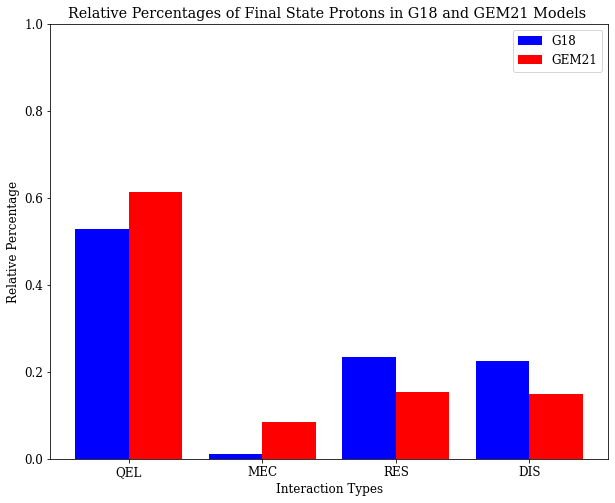

In [90]:
plt.bar(X_axis - 0.2, G18_Proton_Percent_List, 0.4, label = 'G18')
plt.bar(X_axis + 0.2, G21_Proton_Percent_List, 0.4, label = 'GEM21', color='r')
plt.ylim(0.0, 1.0)
plt.xticks(X_axis, X)
plt.xlabel("Interaction Types")
plt.ylabel("Relative Percentage")
plt.title("Relative Percentages of Final State Protons in G18 and GEM21 Models ")
plt.legend()
plt.show()

In [ ]:
plt.bar(X_axis - 0.2, G18_Neutron_Percent_List, 0.4, label = 'G18')
plt.bar(X_axis + 0.2, G21_Neutron_Percent_List, 0.4, label = 'GEM21', color='r')
plt.ylim(0.0, 1.0)
plt.xticks(X_axis, X)
plt.xlabel("Interaction Types")
plt.ylabel("Relative Percentage")
plt.title("Relative Percentages of Final State Neutrons in G18 and GEM21 Models ")
plt.legend()
plt.show()

In [ ]:
plt.bar(X_axis - 0.2, G18_ProNeu_Percent_List, 0.4, label = 'G18')
plt.bar(X_axis + 0.2, G21_ProNeu_Percent_List, 0.4, label = 'GEM21', color='r')
plt.ylim(0.0, 1.0)
plt.xticks(X_axis, X)
plt.xlabel("Interaction Types")
plt.ylabel("Relative Percentage")
plt.title("Relative Percentages of Final State Protons and Neutrons in G18 and GEM21 Models ")
plt.legend()
plt.show()

In [ ]:
#limiting final state protons to some num

In [149]:
bins = 100
x_start = 0
x_end = 4.0 #GeV
G18_Proton_Cut_Percent_List = []
G18_Neutron_Cut_Percent_List = []
G18_ProNeu_Cut_Percent_List = []
G18_Particle_Cut_lists = [G18_Proton_Cut_Percent_List, G18_Neutron_Cut_Percent_List, G18_ProNeu_Cut_Percent_List]
particles = ["nfp", "nfn", "n_proton_neutron"]
run = 0
cut_num = 1 #is this right
for particle in particles:
    df_gst_G18_02a_2Par = df_gst_G18_02a_all.Filter(f"{particle}<={cut_num}")
    G18_Particle_Cut_QEL_Ang = df_gst_G18_02a_2Par.Filter("qel==1").Histo1D(("G18_Particle_Cut_QEL_Ang", "", bins, x_start, x_end), f"{particle}")
    G18_Particle_Cut_MEC_Ang = df_gst_G18_02a_2Par.Filter("mec==1").Histo1D(("G18_Particle_Cut_MEC_Ang", "", bins, x_start, x_end), f"{particle}")
    G18_Particle_Cut_RES_Ang = df_gst_G18_02a_2Par.Filter("res==1").Histo1D(("G18_Particle_Cut_RES_Ang", "", bins, x_start, x_end), f"{particle}")
    G18_Particle_Cut_DIS_Ang = df_gst_G18_02a_2Par.Filter("dis==1").Histo1D(("G18_Particle_Cut_DIS_Ang", "", bins, x_start, x_end), f"{particle}")
    G18_Particle_Cut_Counts = [G18_Particle_Cut_QEL_Ang.Integral(), G18_Particle_Cut_MEC_Ang.Integral(), G18_Particle_Cut_RES_Ang.Integral(), G18_Particle_Cut_DIS_Ang.Integral()]
    G18_Particle_Cut_total = G18_Particle_Cut_Counts[0] + G18_Particle_Cut_Counts[1] + G18_Particle_Cut_Counts[2] + G18_Particle_Cut_Counts[3] 
    G18_Particle_Cut_lists[run].append(G18_Particle_Cut_Counts[0]/G18_Particle_Cut_total)
    G18_Particle_Cut_lists[run].append(G18_Particle_Cut_Counts[1]/G18_Particle_Cut_total)
    G18_Particle_Cut_lists[run].append(G18_Particle_Cut_Counts[2]/G18_Particle_Cut_total)
    G18_Particle_Cut_lists[run].append(G18_Particle_Cut_Counts[3]/G18_Particle_Cut_total)
    run += 1
print(G18_Proton_Cut_Percent_List, G18_Neutron_Cut_Percent_List, G18_ProNeu_Cut_Percent_List)

runtime_error: Template method resolution failed:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  none of the 4 overloaded methods succeeded. Full details:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RRange<ROOT::Detail::RDF::RLoopManager>,void>::Filter(experimental::basic_string_view<char,char_traits<char> > expression, experimental::basic_string_view<char,char_traits<char> > name = "") =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.


input_line_528:2:30: error: use of undeclared identifier 'n_proton_neutron'
auto lambda100 = [](){return n_proton_neutron<=1
                             ^
input_line_529:2:30: error: use of undeclared identifier 'n_proton_neutron'
auto lambda100 = [](){return n_proton_neutron<=1
                             ^
input_line_530:2:30: error: use of undeclared identifier 'n_proton_neutron'
auto lambda100 = [](){return n_proton_neutron<=1
                             ^
input_line_531:2:30: error: use of undeclared identifier 'n_proton_neutron'
auto lambda100 = [](){return n_proton_neutron<=1
                             ^
input_line_532:2:30: error: use of undeclared identifier 'n_proton_neutron'
auto lambda100 = [](){return n_proton_neutron<=1
                             ^
input_line_533:2:30: error: use of undeclared identifier 'n_proton_neutron'
auto lambda100 = [](){return n_proton_neutron<=1
                             ^
input_line_534:2:30: error: use of undeclared identifier 'n_prot

In [ ]:
bins = 100
x_start = 0
x_end = 4.0 #GeV
G21_Proton_Cut_Percent_List = []
G21_Neutron_Cut_Percent_List = []
G21_ProNeu_Cut_Percent_List = []
G21_Particle_Cut_lists = [G21_Proton_Cut_Percent_List, G21_Neutron_Cut_Percent_List, G21_ProNeu_Cut_Percent_List]
particles = ["nfp", "nfn", "n_proton_neutron"]
run = 0
cut_num = 1 #is this right
for particle in particles:
    df_gst_GEM21_11b_2Par = df_gst_GEM21_11b_all.Filter(f"{particle}<={cut_num}")
    G21_Particle_Cut_QEL_Ang = df_gst_GEM21_11b_2Par.Filter("qel==1").Histo1D(("G21_Particle_Cut_QEL_Ang", "", bins, x_start, x_end), f"{particle}")
    G21_Particle_Cut_MEC_Ang = df_gst_GEM21_11b_2Par.Filter("mec==1").Histo1D(("G21_Particle_Cut_MEC_Ang", "", bins, x_start, x_end), f"{particle}")
    G21_Particle_Cut_RES_Ang = df_gst_GEM21_11b_2Par.Filter("res==1").Histo1D(("G21_Particle_Cut_RES_Ang", "", bins, x_start, x_end), f"{particle}")
    G21_Particle_Cut_DIS_Ang = df_gst_GEM21_11b_2Par.Filter("dis==1").Histo1D(("G21_Particle_Cut_DIS_Ang", "", bins, x_start, x_end), f"{particle}")
    G21_Particle_Cut_Counts = [G21_Particle_Cut_QEL_Ang.Integral(), G21_Particle_Cut_MEC_Ang.Integral(), G21_Particle_Cut_RES_Ang.Integral(), G21_Particle_Cut_DIS_Ang.Integral()]
    G21_Particle_Cut_total = G21_Particle_Cut_Counts[0] + G21_Particle_Cut_Counts[1] + G21_Particle_Cut_Counts[2] + G21_Particle_Cut_Counts[3] 
    G21_Particle_Cut_lists[run].append(G21_Particle_Cut_Counts[0]/G21_Particle_Cut_total)
    G21_Particle_Cut_lists[run].append(G21_Particle_Cut_Counts[1]/G21_Particle_Cut_total)
    G21_Particle_Cut_lists[run].append(G21_Particle_Cut_Counts[2]/G21_Particle_Cut_total)
    G21_Particle_Cut_lists[run].append(G21_Particle_Cut_Counts[3]/G21_Particle_Cut_total)
    run += 1
print(G21_Proton_Cut_Percent_List, G21_Neutron_Cut_Percent_List, G21_ProNeu_Cut_Percent_List)

In [ ]:
plt.bar(X_axis - 0.2, G18_Proton_Cut_Percent_List, 0.4, label = 'G18')
plt.bar(X_axis + 0.2, G21_Proton_Cut_Percent_List, 0.4, label = 'GEM21', color='r')
plt.ylim(0.0, 1.0)
plt.xticks(X_axis, X)
plt.xlabel("Interaction Types")
plt.ylabel("Relative Percentage")
plt.title("Relative Percentages of One Final State Proton in G18 and GEM21 Models ")
plt.legend()
plt.show()

In [ ]:
plt.bar(X_axis - 0.2, G18_Neutron_Cut_Percent_List, 0.4, label = 'G18')
plt.bar(X_axis + 0.2, G21_Neutron_Cut_Percent_List, 0.4, label = 'GEM21', color='r')
plt.ylim(0.0, 1.0)
plt.xticks(X_axis, X)
plt.xlabel("Interaction Types")
plt.ylabel("Relative Percentage")
plt.title("Relative Percentages of One Final State Neutron in G18 and GEM21 Models ")
plt.legend()
plt.show()

In [ ]:
plt.bar(X_axis - 0.2, G18_ProNeu_Percent_List, 0.4, label = 'G18')
plt.bar(X_axis + 0.2, G21_ProNeu_Cut_Percent_List, 0.4, label = 'GEM21', color='r')
plt.ylim(0.0, 1.0)
plt.xticks(X_axis, X)
plt.xlabel("Interaction Types")
plt.ylabel("Relative Percentage")
plt.title("Relative Percentages of One Final State Proton/Neutron in G18 and GEM21 Models ")
plt.legend()
plt.show()

In [148]:
#G18 Model 
#df_gst_G18_02a_PTAng = df_gst_G18_02a_all.Filter(f"ptl>{lep_accept_pt}")
G18_PTCut_QEL_Ang = df_gst_G18_02a_all.Filter("qel==1").Histo1D(("G18_PTCut_QEL_Ang", "", bins, x_start, x_end), "sum_kef_proton")
G18_PTCut_MEC_Ang = df_gst_G18_02a_all.Filter("mec==1").Histo1D(("G18_PTCut_MEC_Ang", "", bins, x_start, x_end), "sum_kef_proton")
G18_PTCut_RES_Ang = df_gst_G18_02a_all.Filter("res==1").Histo1D(("G18_PTCut_RES_Ang", "", bins, x_start, x_end), "sum_kef_proton")
G18_PTCut_DIS_Ang = df_gst_G18_02a_all.Filter("dis==1").Histo1D(("G18_PTCut_DIS_Ang", "", bins, x_start, x_end), "sum_kef_proton")
G18_theta_range = [G18_PTCut_QEL_Ang.Integral(), G18_PTCut_MEC_Ang.Integral(), G18_PTCut_RES_Ang.Integral(), G18_PTCut_DIS_Ang.Integral()]

TypeError: Template method resolution failed:
  none of the 4 overloaded methods succeeded. Full details:
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(experimental::basic_string_view<char,char_traits<char> > vName) =>
    TypeError: takes at most 1 arguments (2 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(const ROOT::RDF::TH1DModel& model, experimental::basic_string_view<char,char_traits<char> > vName, experimental::basic_string_view<char,char_traits<char> > wName) =>
    TypeError: takes at least 3 arguments (2 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(experimental::basic_string_view<char,char_traits<char> > vName, experimental::basic_string_view<char,char_traits<char> > wName) =>
    TypeError: could not convert argument 1
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(const ROOT::RDF::TH1DModel& model = {"", "", 128U, 0., 0.}, experimental::basic_string_view<char,char_traits<char> > vName = "") =>
    runtime_error: Unknown column: sum_kef_proton
  none of the 4 overloaded methods succeeded. Full details:
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(experimental::basic_string_view<char,char_traits<char> > vName) =>
    TypeError: takes at most 1 arguments (2 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(const ROOT::RDF::TH1DModel& model, experimental::basic_string_view<char,char_traits<char> > vName, experimental::basic_string_view<char,char_traits<char> > wName) =>
    TypeError: takes at least 3 arguments (2 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(experimental::basic_string_view<char,char_traits<char> > vName, experimental::basic_string_view<char,char_traits<char> > wName) =>
    TypeError: could not convert argument 1
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(const ROOT::RDF::TH1DModel& model = {"", "", 128U, 0., 0.}, experimental::basic_string_view<char,char_traits<char> > vName = "") =>
    runtime_error: Unknown column: sum_kef_proton
  Failed to instantiate "Histo1D(ROOT::RDF::TH1DModel*,std::string)"